# MLiM: Homework Assignment 2

In [1]:
import os
import pandas as pd
from  tqdm import tqdm
import numpy as np
os.getcwd()

'/Users/asmir/mlim_project/mlim/exercises'

## Part 2: Clustering EDA

Pipeline to cluster customers based on past purchases. (Instacart data set)
* EDA
* Feature Engineering
    * motivation --> why useful to dinstinguish customers 
* Pipeline
    * structure code in pipeline stages
    * config files (parameters) 
    * tune hyperparameters (k in kmeans)
    * meaningful evaluation metrics for clustering (e.g.silhoutte score)
* Study clusters
    * stat sig. diffeences between customer groups? 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [34]:
order_products_prior_df = pd.read_csv("order_products__prior.csv")
order_products_train_df = pd.read_csv("order_products__train.csv")
orders_df = pd.read_csv("orders.csv")
products_df = pd.read_csv("products.csv")
aisles_df = pd.read_csv("aisles.csv")
departments_df = pd.read_csv("departments.csv")

In [35]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [36]:
order_products_prior_df.shape # 32.43 mm

(32434489, 4)

In [38]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [39]:
order_products_train_df.shape # 1.38 mm

(1384617, 4)

In [40]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [41]:
orders_df.days_since_prior_order.isna().count()

3421083

In [42]:
orders_df.eval_set.value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [43]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


* can be joined to order_products_prior_df using **product_id**

In [44]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


* can be joined to order_products_prior_df using **aisle_id** 

In [45]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


* can be joined to order_products_prior_df using **department_id** 

In [46]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, orders_df, on='order_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [47]:
order_products_train_df = pd.merge(order_products_train_df, products_df, on='product_id', how='left')
order_products_train_df = pd.merge(order_products_train_df, aisles_df, on='aisle_id', how='left')
order_products_train_df = pd.merge(order_products_train_df, departments_df, on='department_id', how='left')
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9.0
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,train,4,4,10,9.0
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9.0


#### This is my undrstanding of the dataset structure:

* Users are identified by user_id in the orders csv file. Each row of the orders csv file represents an order made by a user. Orders are identified by order_id.

* Each order of a user is characterized by an order_number which specifies when it has been made with respect to the others of the same user.

* Each order consists of a set of product each characterized by an add_to_cart_order feature representing the sequence in which they have been added to the cart in that order.

* For each user we may have n-1 prior orders and 1 train order OR n-1 prior orders and 1 test order.

#### When do people order?

##### Day of the week

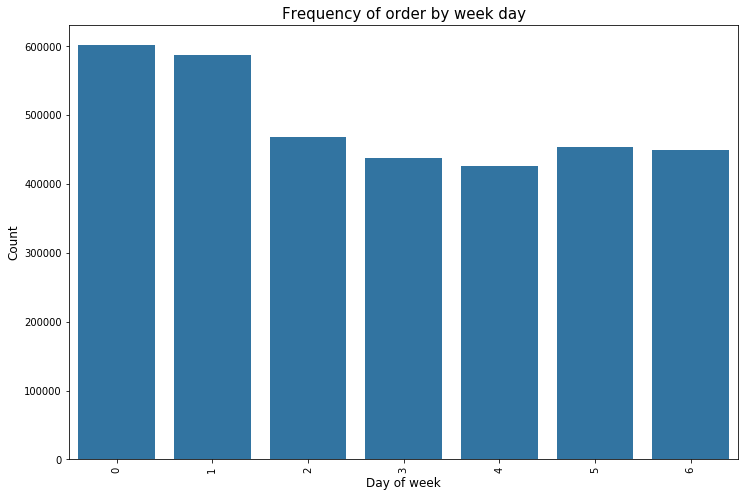

In [50]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

0 and 1 seem to be Saturday and Sunday. Orders are high during the weekend.

##### Time of the day

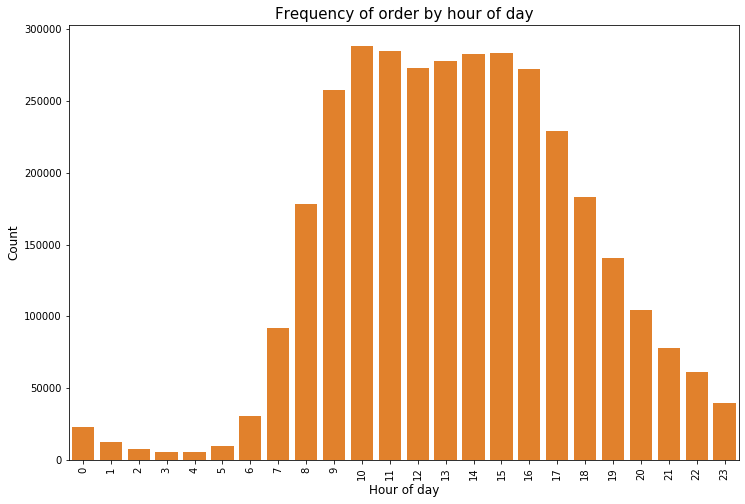

In [51]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

Most orders are made during the day time (8 am - 6 pm)

##### Time-Day Order Distribution

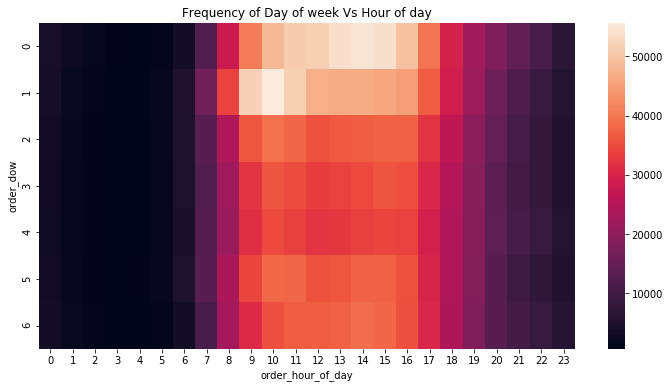

In [52]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

Saturday mid day and Sunday mornings are the prime time for orders. 

#### When do people order again? 

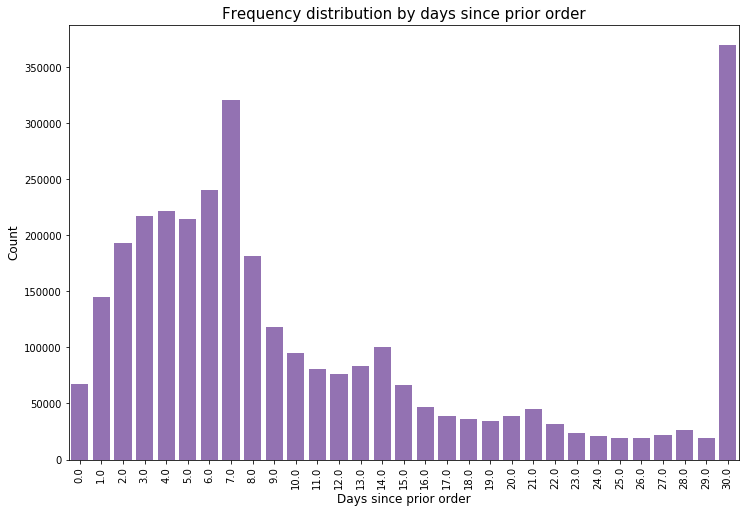

In [53]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[4])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

Customers mostly order either once a week (peak at 7) or once a month (peak at 30).
Note the small bumps at 2 weeks (14) and 3 weeks (21).

#### How many prior orders do cusotmers have?

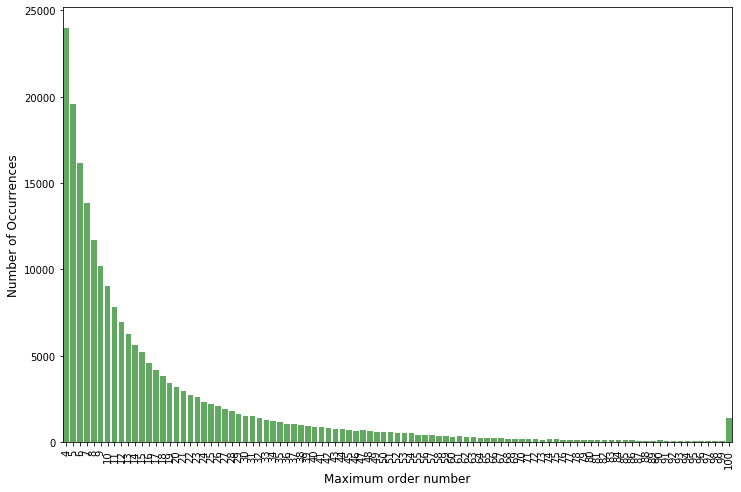

In [54]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#### How many items do customers shop?

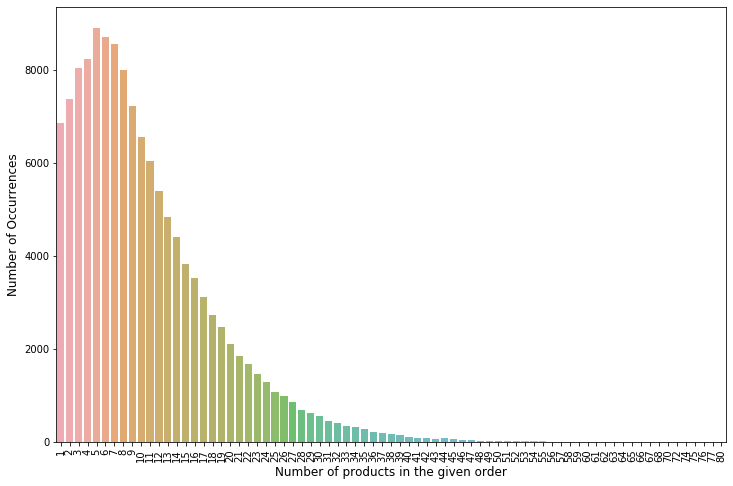

In [55]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#### Bestsellers

In [56]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


The bestsellers are mostly fruits, and a lot of them being organic.

#### Top Aisles

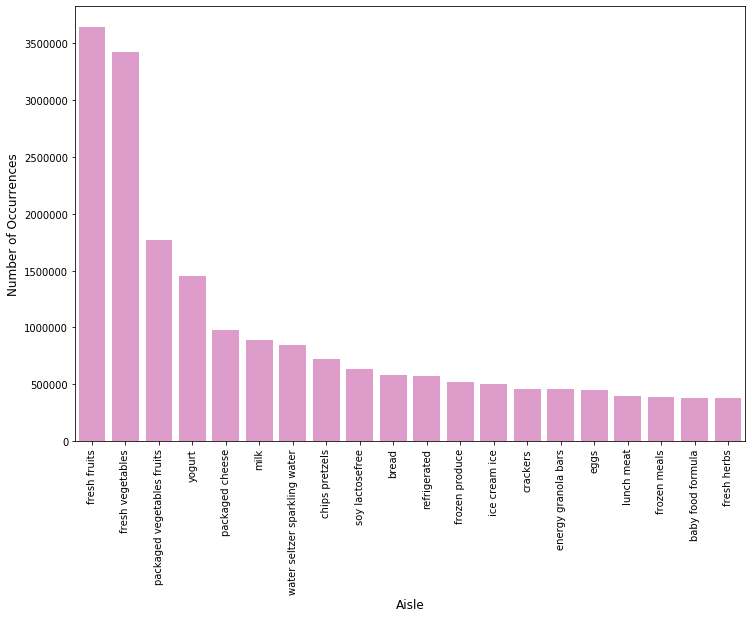

In [57]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[6])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#### Top departments

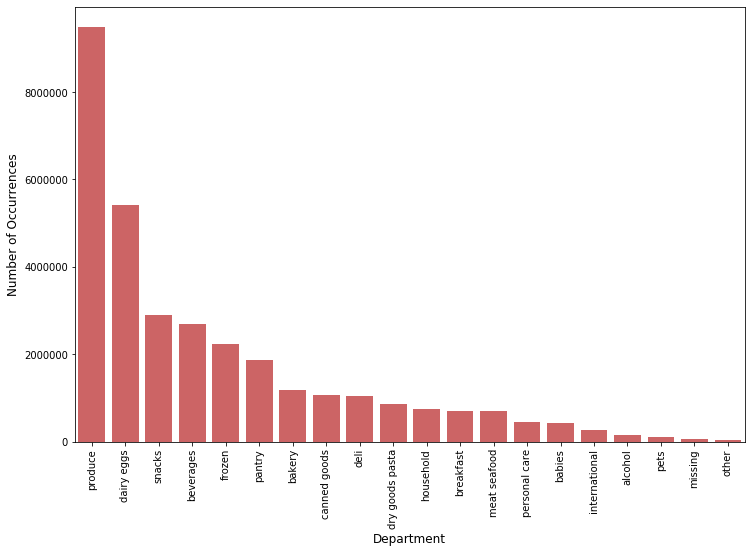

In [58]:
cnt_srs = order_products_prior_df['department'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Produce is the largest department by far. 
Let´s check re-order ratios by department.

#### Department-Product plots

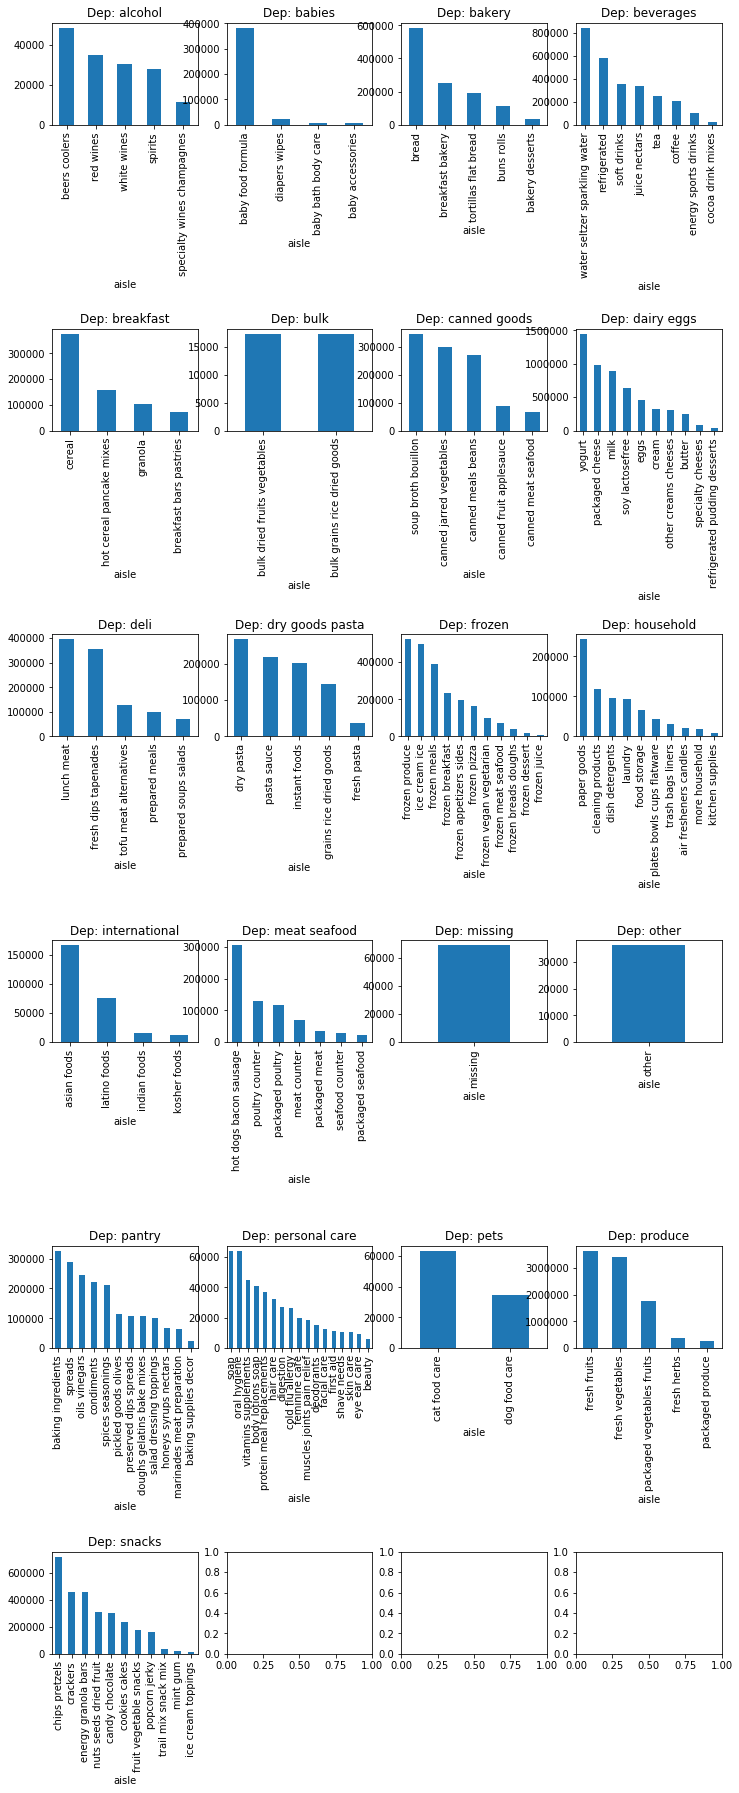

In [59]:
# plot departments volume, split by aisles
f, axarr = plt.subplots(6, 4, figsize=(12, 30))
for i,e in enumerate(departments_df.department.sort_values(ascending=True)):
    axarr[i//4, i%4].set_title('Dep: {}'.format(e))
    order_products_prior_df[order_products_prior_df.department==e].groupby(['aisle']).count()['product_id']\
    .sort_values(ascending=False).plot(kind='bar', ax=axarr[i//4, i%4])
f.subplots_adjust(hspace=2)

#### Department reorder ratio

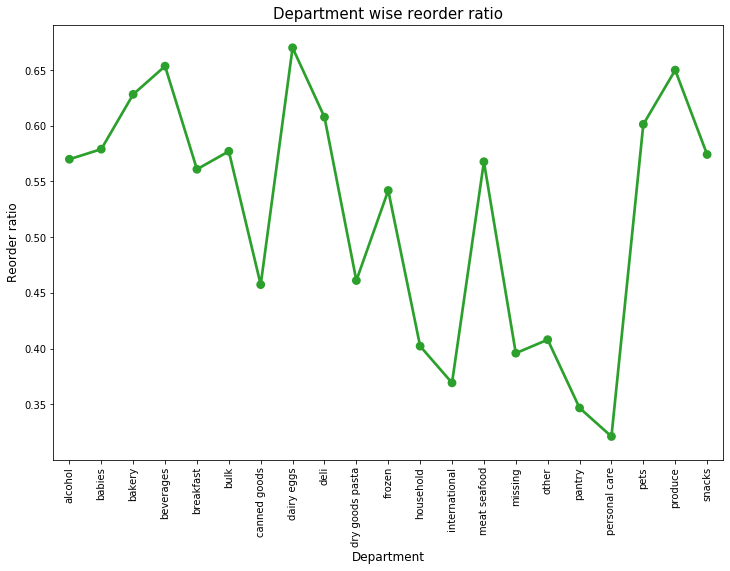

In [60]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Personal care has lowest reorder ratio and dairy eggs have highest reorder ratio.

#### Aisle - Reorder ratio:

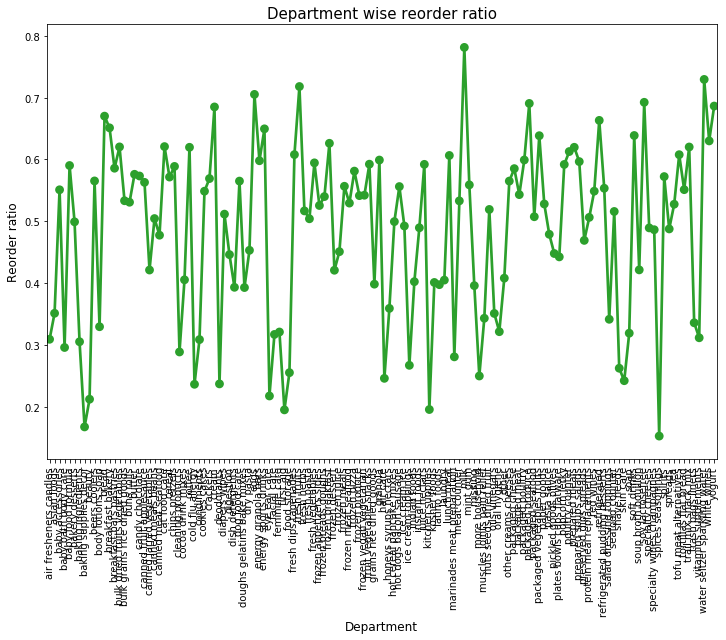

In [61]:
grouped_df = order_products_prior_df.groupby(["aisle"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['aisle'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [62]:
pd.set_option('display.max_rows', 150)

In [63]:
grouped_df.sort_values(by=['reordered'], ascending=False)

,aisle,reordered
83,milk,0.781428
131,water seltzer sparkling water,0.729593
50,fresh fruits,0.718104
41,eggs,0.705366
119,soy lactosefree,0.692551
96,packaged produce,0.690734
133,yogurt,0.686489
33,cream,0.685046
11,bread,0.670168
110,refrigerated,0.663302


#### Add to Cart - Reorder ratio:

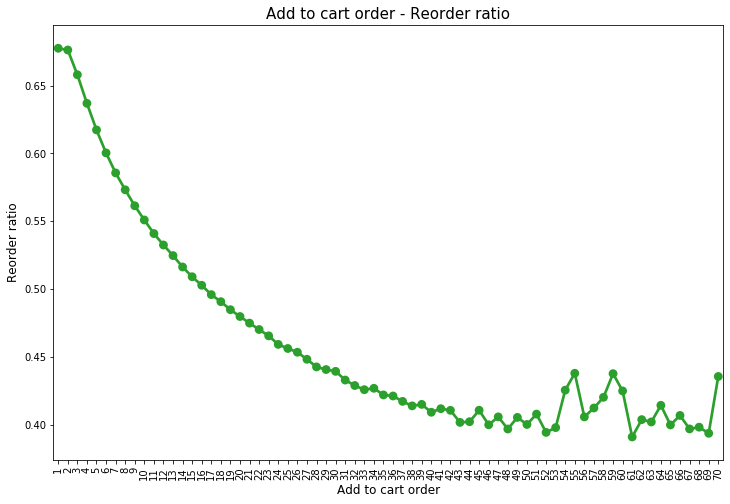

In [64]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"] = np.where(order_products_prior_df["add_to_cart_order_mod"]>70,70,order_products_prior_df["add_to_cart_order_mod"])
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

### Encoding Cyclical Features: Hour of Day

We want to encode hour of day as a cyclical feature, since that allows our algorithm to understand that 23 to 0 is only one hour away and not 23. 

A common method for encoding cyclical data is to transform the data into two dimensions using a sine and consine transformation.

We can do that using the following transformations:

xsin=sin(2∗π∗x/ max(x))

xcos=cos(2∗π∗x / max(x))
 
Let's do this for our hourly data:

In [65]:
orders_df['hour_sin'] = np.sin(2 * np.pi * orders_df['order_hour_of_day']/23.0)
orders_df['hour_cos'] = np.cos(2 * np.pi * orders_df['order_hour_of_day']/23.0)

## Part 3: Predict time of customer´s next order

Marketing campaign which targets customers who visit his shop infrequently.  

* Predict whether a customer will visit the shop within 14 days after last purchase
    * 10% discount (basket amount at checkout) for customers who will **NOT** visit shop within 14 days of last purchase
        * 10% discount redeemable if spend >= 25€
        * 1€ cost for voucher 
* Predictions that will be benchmarked using AUC metric
    * Probability --> Apply Threshold --> Binary Prediction
    
---

* orders.parquet: Information about orders
* baskets.parquet: Products purchased in each order
* aisles.parquet: Product´s aisles: IDs and desc.
* departments.parquet: Product´s departments: IDs and desc.
* products.parquet: Product master: IDs, desc., links to aisles and departments
* prediction_index.parquet: input for making predictions. 

In [3]:
import os
import tqdm
import warnings
import functools

import numpy as np
import pandas as pd

import seaborn as sns
import sklearn.preprocessing
import sklearn.neighbors
import sklearn.model_selection
import sklearn.metrics

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

In [4]:
#!pip install pyarrow
import pyarrow
#!pip install fastparquet
import fastparquet

### Data Loading

In [5]:
aisles = pd.read_parquet("ex2/aisles.parquet")

In [6]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [6]:
departments = pd.read_parquet("ex2/departments.parquet")

In [8]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [7]:
products = pd.read_parquet("ex2/products.parquet")

In [10]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
orders = pd.read_parquet("ex2/orders.parquet")

In [12]:
orders.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,2,8,NaN
1,2398795,1,2,3,7,15.0
2,473747,1,3,3,12,21.0
3,2254736,1,4,4,7,29.0
4,431534,1,5,4,15,28.0


In [113]:
#orders["reordered_14d"] = np.where(orders["days_since_prior_order"] > 14,0,1)

In [9]:
baskets = pd.read_parquet("ex2/baskets.parquet")

In [14]:
baskets.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
3,2,45918,4,1
7,2,1819,8,1
4,2,30035,5,0


In [10]:
prediction_index = pd.read_parquet("ex2/prediction_index.parquet")

In [16]:
prediction_index

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5
...,...,...
206204,206205,4
206205,206206,68
206206,206207,17
206207,206208,50


In [11]:
baskets = pd.merge(baskets, products, on='product_id', how='left')
baskets = pd.merge(baskets, aisles, on='aisle_id', how='left')
baskets = pd.merge(baskets, departments, on='department_id', how='left')
df = pd.merge(baskets, orders, on="order_id", how='left')
df.shape

(32434489, 14)

In [18]:
df

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,3,5,9,8.0
2,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,3,5,9,8.0
3,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13,spreads,pantry,202279,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,3,5,9,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,35211,5,0,Organic Strawberry & Mango Dried Tiny Fruits,92,18,baby food formula,babies,25247,24,2,6,21.0
32434485,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent,74,17,dish detergents,household,25247,24,2,6,21.0
32434486,3421083,11352,7,0,Organic Mini Sandwich Crackers Peanut Butter,78,19,crackers,snacks,25247,24,2,6,21.0
32434487,3421083,4600,8,0,All Natural French Toast Sticks,52,1,frozen breakfast,frozen,25247,24,2,6,21.0


In [12]:
#clearing memory 
del baskets
del products
del aisles
del departments

### Excluding last order to prevent target leakage 

In [13]:
# list of orders - they are alredy sorted correctly
loo = df[["order_id","user_id","order_number"]].sort_values(by=["order_number"]).groupby(by="user_id").agg({'order_id':lambda x: list(x)}).reset_index(drop=False)
loo = loo.rename(columns={"order_id": "list_of_orders"})
# remove dublicates
loo["list_of_orders"] = loo["list_of_orders"].apply(lambda x: list(dict.fromkeys(x)))
loo.head()

,user_id,list_of_orders
0,1,"[2539329, 2398795, 473747, 2254736, 431534, 33..."
1,2,"[2168274, 1501582, 1901567, 738281, 1673511, 1..."
2,3,"[1374495, 444309, 3002854, 2037211, 2710558, 1..."
3,4,"[3343014, 2030307, 691089, 94891, 2557754]"
4,5,"[2717275, 1909121, 2267326, 157374]"


In [14]:
# get the last 4 order_id's
loo["order_lag_0"] = loo["list_of_orders"].apply(lambda x: x[-1])
loo["order_lag_1"] = loo["list_of_orders"].apply(lambda x: x[-2])
loo["order_lag_2"] = loo["list_of_orders"].apply(lambda x: x[-3])
loo["order_lag_3"] = loo["list_of_orders"].apply(lambda x: x[-4] if len(x)>3 else -1)

In [15]:
loo

,user_id,list_of_orders,order_lag_0,order_lag_1,order_lag_2,order_lag_3
0,1,"[2539329, 2398795, 473747, 2254736, 431534, 33...",2550362,2295261,3108588,550135
1,2,"[2168274, 1501582, 1901567, 738281, 1673511, 1...",839880,3268552,3186735,1402090
2,3,"[1374495, 444309, 3002854, 2037211, 2710558, 1...",1402502,521107,676467,3160850
3,4,"[3343014, 2030307, 691089, 94891, 2557754]",2557754,94891,691089,2030307
4,5,"[2717275, 1909121, 2267326, 157374]",157374,2267326,1909121,2717275
...,...,...,...,...,...,...
206204,206205,"[969311, 2658896, 414137]",414137,2658896,969311,-1
206205,206206,"[3189322, 3351137, 540764, 2975608, 2028659, 5...",1904200,2986341,2750895,2643521
206206,206207,"[2166133, 1074448, 1666077, 2364140, 2277235, ...",1005822,2991173,2832273,1452193
206207,206208,"[2227043, 1959749, 3392839, 731227, 2936891, 2...",1882108,1285346,2239861,3059777


In [16]:
df2 = df[~df.order_id.isin(loo["order_lag_0"])]

In [145]:
#test = df[df.order_id.isin(loo["order_lag_0"])]

In [24]:
df2 

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,3,5,9,8.0
2,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,3,5,9,8.0
3,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13,spreads,pantry,202279,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,3,5,9,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,35211,5,0,Organic Strawberry & Mango Dried Tiny Fruits,92,18,baby food formula,babies,25247,24,2,6,21.0
32434485,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent,74,17,dish detergents,household,25247,24,2,6,21.0
32434486,3421083,11352,7,0,Organic Mini Sandwich Crackers Peanut Butter,78,19,crackers,snacks,25247,24,2,6,21.0
32434487,3421083,4600,8,0,All Natural French Toast Sticks,52,1,frozen breakfast,frozen,25247,24,2,6,21.0


In [147]:
test

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
219,25,22105,5,0,Ultra Thin Sliced Provolone Cheese,21,16,packaged cheese,dairy eggs,59897,19,6,10,25.0
220,25,9755,1,1,Original Popcorn,23,19,popcorn jerky,snacks,59897,19,6,10,25.0
221,25,31487,2,0,Boomchickapop Sweet & Salty Kettle Corn,23,19,popcorn jerky,snacks,59897,19,6,10,25.0
222,25,48299,14,1,Baby Cut Carrots,123,4,packaged vegetables fruits,produce,59897,19,6,10,25.0
223,25,37449,13,0,Natural Muenster Cheese,21,16,packaged cheese,dairy eggs,59897,19,6,10,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434313,3421059,48845,2,1,Roasted Brussels Sprouts,13,20,prepared meals,deli,79937,7,6,2,30.0
32434314,3421059,33894,1,0,Goldfish Cheddar Baked Snack Crackers Multi Packs,78,19,crackers,snacks,79937,7,6,2,30.0
32434315,3421059,13077,3,0,Pepperoni Pizza,79,1,frozen pizza,frozen,79937,7,6,2,30.0
32434420,3421073,49187,1,0,"Sesame Oil, Refined",19,13,oils vinegars,pantry,103510,30,4,10,15.0


In [144]:
df2[df2['user_id']== 5] # only 3 orders now for user 5 --> we deleted the latest order 

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
18099544,1909121,6808,2,0,Organic Spinach & Cheese Tortellini,12,9,fresh pasta,dry goods pasta,5,2,0,16,11.0
18099545,1909121,24535,3,1,Plain Whole Milk Yogurt,120,16,yogurt,dairy eggs,5,2,0,16,11.0
18099546,1909121,11777,4,1,Red Raspberries,123,4,packaged vegetables fruits,produce,5,2,0,16,11.0
18099547,1909121,21616,5,0,Organic Baby Arugula,123,4,packaged vegetables fruits,produce,5,2,0,16,11.0
18099548,1909121,18761,6,0,Balsamic Vinegar Of Modena,19,13,oils vinegars,pantry,5,2,0,16,11.0
18099549,1909121,26604,7,1,Organic Blackberries,24,4,fresh fruits,produce,5,2,0,16,11.0
18099550,1909121,13870,8,0,Lightly Salted Baked Snap Pea Crisps,107,19,chips pretzels,snacks,5,2,0,16,11.0
18099551,1909121,13988,9,0,Snow Peas,83,4,fresh vegetables,produce,5,2,0,16,11.0
18099552,1909121,43693,1,1,Whole Vitamin D Milk,84,16,milk,dairy eggs,5,2,0,16,11.0
21495571,2267326,40706,5,0,Organic Grape Tomatoes,123,4,packaged vegetables fruits,produce,5,3,3,18,10.0


### Feature Engineering:
* ratio re-ordered within 14 days
* % fruits, % veg, % eggs in orders
* count of orders
* count of products bought
* avg_products/order
* mbr_duration_weeks
* orders/time 
* avg_days_between_order
* lag orders

In [17]:
df2["reordered_14d"] = np.where(df2["days_since_prior_order"] > 14,0,1)

In [18]:
df['reorded_w14d_ratio'] = df2.groupby(['user_id'])['reordered_14d'].transform('mean')

In [19]:
df['reordered_ratio'] = df2.groupby(['user_id'])['reordered'].transform('mean')

In [20]:
df['no_orders'] = df2.groupby(['user_id'])['order_number'].transform('max')

In [21]:
df['no_item_orders'] = df2.groupby(['user_id'])['product_id'].transform('count')

In [22]:
df['avg_no_items'] = df['no_item_orders']/df['no_orders']

In [23]:
df['inter-order-time'] = df2.groupby(['user_id'])['days_since_prior_order'].transform('sum')

In [24]:
df['orders_per_day'] = df['no_orders']/(df['inter-order-time']+1)

In [25]:
df['avg_days_betweeen_orders'] = df2.groupby(['user_id'])['days_since_prior_order'].transform('mean')

In [26]:
df2 = pd.get_dummies(df2, prefix=['dep'], columns=['department'])

In [27]:
df2.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'aisle', 'user_id',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'reordered_14d', 'dep_alcohol', 'dep_babies',
       'dep_bakery', 'dep_beverages', 'dep_breakfast', 'dep_bulk',
       'dep_canned goods', 'dep_dairy eggs', 'dep_deli', 'dep_dry goods pasta',
       'dep_frozen', 'dep_household', 'dep_international', 'dep_meat seafood',
       'dep_missing', 'dep_other', 'dep_pantry', 'dep_personal care',
       'dep_pets', 'dep_produce', 'dep_snacks'],
      dtype='object')

In [28]:
df['%_alc'] = df2.groupby(['user_id'])['dep_alcohol'].transform('mean')

In [29]:
df['%_babies'] = df2.groupby(['user_id'])['dep_babies'].transform('mean')

In [30]:
df['%_bakery'] = df2.groupby(['user_id'])['dep_bakery'].transform('mean')

In [31]:
df['%_beverages'] = df2.groupby(['user_id'])['dep_beverages'].transform('mean')

In [32]:
df['%_breakfast'] = df2.groupby(['user_id'])['dep_breakfast'].transform('mean')

In [33]:
df['%_bulk'] = df2.groupby(['user_id'])['dep_bulk'].transform('mean')

In [34]:
df['%_canned_goods'] = df2.groupby(['user_id'])['dep_canned goods'].transform('mean')

In [35]:
df['%_diary_eggs'] = df2.groupby(['user_id'])['dep_dairy eggs'].transform('mean')

In [36]:
df['%_deli'] = df2.groupby(['user_id'])['dep_deli'].transform('mean')

In [37]:
df['%_pasta'] = df2.groupby(['user_id'])['dep_dry goods pasta'].transform('mean')

In [38]:
df['%_frozen'] = df2.groupby(['user_id'])['dep_frozen'].transform('mean')

In [39]:
df['%_household'] = df2.groupby(['user_id'])['dep_household'].transform('mean')

In [40]:
df['%_international'] = df2.groupby(['user_id'])['dep_international'].transform('mean')

In [41]:
df['%_meat_seafood'] = df2.groupby(['user_id'])['dep_meat seafood'].transform('mean')

In [42]:
df['%_missing'] = df2.groupby(['user_id'])['dep_missing'].transform('mean')

In [43]:
df['%_other'] = df2.groupby(['user_id'])['dep_other'].transform('mean')

In [44]:
df['%_pantry'] = df2.groupby(['user_id'])['dep_pantry'].transform('mean')

In [45]:
df['%_personal_care'] = df2.groupby(['user_id'])['dep_personal care'].transform('mean')

In [46]:
df['%_pets'] = df2.groupby(['user_id'])['dep_pets'].transform('mean')

In [47]:
df['%_produce'] = df2.groupby(['user_id'])['dep_produce'].transform('mean')

In [48]:
df['%_snacks'] = df2.groupby(['user_id'])['dep_snacks'].transform('mean')

In [49]:
df2.drop(['dep_alcohol', 'dep_babies',
       'dep_bakery', 'dep_beverages', 'dep_breakfast', 'dep_bulk',
       'dep_canned goods', 'dep_dairy eggs', 'dep_deli', 'dep_dry goods pasta',
       'dep_frozen', 'dep_household', 'dep_international', 'dep_meat seafood',
       'dep_missing', 'dep_other', 'dep_pantry', 'dep_personal care',
       'dep_pets', 'dep_produce', 'dep_snacks'], axis=1, inplace=True)

In [51]:
pd.set_option('display.max_columns', None)

In [50]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,...,%_household,%_international,%_meat_seafood,%_missing,%_other,%_pantry,%_personal_care,%_pets,%_produce,%_snacks
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,...,0.012821,0.0,0.0,0.0,0.012821,0.461538,0.051282,0.0,0.25641,0.012821
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,...,0.012821,0.0,0.0,0.0,0.012821,0.461538,0.051282,0.0,0.25641,0.012821
2,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,...,0.012821,0.0,0.0,0.0,0.012821,0.461538,0.051282,0.0,0.25641,0.012821
3,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13,spreads,pantry,202279,...,0.012821,0.0,0.0,0.0,0.012821,0.461538,0.051282,0.0,0.25641,0.012821
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,...,0.012821,0.0,0.0,0.0,0.012821,0.461538,0.051282,0.0,0.25641,0.012821


In [52]:
df_1 = df.groupby(by="order_id").mean()

In [53]:
df_1.head()

,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reorded_w14d_ratio,reordered_ratio,no_orders,no_item_orders,avg_no_items,inter-order-time,orders_per_day,avg_days_betweeen_orders,%_alc,%_babies,%_bakery,%_beverages,%_breakfast,%_bulk,%_canned_goods,%_diary_eggs,%_deli,%_pasta,%_frozen,%_household,%_international,%_meat_seafood,%_missing,%_other,%_pantry,%_personal_care,%_pets,%_produce,%_snacks
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,27867.444444,5.0,0.666667,78.666667,10.333333,202279.0,3.0,5.0,9.0,8.0,0.384615,0.487179,7.0,78.0,11.142857,1389.0,0.005036,20.426471,0.0,0.000000,0.000000,0.012821,0.000000,0.0,0.051282,0.128205,0.000000,0.000000,0.000000,0.012821,0.000000,0.000000,0.00000,0.012821,0.461538,0.051282,0.000000,0.256410,0.012821
3,26582.500000,4.5,1.000000,97.250000,9.375000,205970.0,16.0,5.0,17.0,12.0,0.843949,0.576433,24.0,314.0,13.083333,2967.0,0.008086,9.890000,0.0,0.000000,0.038217,0.019108,0.041401,0.0,0.006369,0.229299,0.000000,0.025478,0.041401,0.003185,0.003185,0.015924,0.00000,0.000000,0.044586,0.066879,0.000000,0.426752,0.038217
4,29740.615385,7.0,0.923077,59.076923,12.846154,178520.0,36.0,1.0,9.0,7.0,1.000000,0.885336,55.0,907.0,16.490909,6022.0,0.009132,6.736018,0.0,0.000000,0.036384,0.190739,0.264609,0.0,0.000000,0.272326,0.007718,0.000000,0.001103,0.003308,0.006615,0.000000,0.00441,0.000000,0.011025,0.004410,0.000000,0.070562,0.126792
5,29484.692308,13.5,0.807692,57.846154,11.653846,156122.0,42.0,6.0,16.0,9.0,0.971579,0.837895,51.0,950.0,18.627451,6506.0,0.007838,6.965739,0.0,0.006316,0.022105,0.096842,0.013684,0.0,0.020000,0.181053,0.056842,0.037895,0.045263,0.101053,0.031579,0.018947,0.00000,0.001053,0.047368,0.021053,0.010526,0.123158,0.165263
6,32744.000000,2.0,0.000000,69.000000,13.666667,22352.0,4.0,1.0,12.0,30.0,0.178571,0.095238,7.0,84.0,12.000000,1873.0,0.003735,23.123457,0.0,0.000000,0.011905,0.178571,0.023810,0.0,0.035714,0.166667,0.035714,0.011905,0.095238,0.023810,0.011905,0.023810,0.00000,0.000000,0.119048,0.000000,0.000000,0.238095,0.023810


In [54]:
# not neede - cannot be interpreted
df_1 = df_1.drop(columns=["aisle_id","department_id"])

In [55]:
df_2 = df_1.groupby(by="user_id").mean()
df_2

,product_id,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,reorded_w14d_ratio,reordered_ratio,no_orders,no_item_orders,avg_no_items,inter-order-time,orders_per_day,avg_days_betweeen_orders,%_alc,%_babies,%_bakery,%_beverages,%_breakfast,%_bulk,%_canned_goods,%_diary_eggs,%_deli,%_pasta,%_frozen,%_household,%_international,%_meat_seafood,%_missing,%_other,%_pantry,%_personal_care,%_pets,%_produce,%_snacks
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,17189.803611,3.450000,0.705833,5.5,2.500000,10.300000,19.555556,0.340000,0.700000,9.0,50.0,5.555556,824.0,0.010909,18.311111,0.000000,0.000000,0.000000,0.220000,0.040000,0.0,0.000000,0.200000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.00000,0.000000,0.020000,0.000000,0.0,0.100000,0.380000
2.0,25507.097335,7.464286,0.447961,7.5,2.142857,10.571429,15.230769,0.670391,0.463687,13.0,179.0,13.769231,2698.0,0.004817,16.253012,0.000000,0.000000,0.011173,0.039106,0.016760,0.0,0.005587,0.234637,0.117318,0.000000,0.089385,0.000000,0.011173,0.005587,0.00000,0.000000,0.055866,0.005587,0.0,0.178771,0.229050
3.0,27813.333333,4.166667,0.658817,6.5,1.083333,16.416667,12.090909,0.792683,0.597561,11.0,82.0,7.454545,806.0,0.013631,11.194444,0.000000,0.000000,0.000000,0.024390,0.000000,0.0,0.000000,0.243902,0.024390,0.036585,0.073171,0.012195,0.000000,0.000000,0.00000,0.000000,0.048780,0.000000,0.0,0.439024,0.097561
4.0,23471.276190,2.300000,0.028571,3.0,4.800000,12.600000,13.750000,0.266667,0.066667,4.0,15.0,3.750000,215.0,0.018519,19.545455,0.133333,0.000000,0.133333,0.200000,0.000000,0.0,0.066667,0.000000,0.000000,0.000000,0.200000,0.133333,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.133333,0.000000
5.0,22770.456692,5.125000,0.377778,2.5,1.750000,16.000000,13.333333,1.000000,0.240000,3.0,25.0,8.333333,149.0,0.020000,10.642857,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.160000,0.000000,0.040000,0.080000,0.000000,0.040000,0.000000,0.00000,0.000000,0.080000,0.000000,0.0,0.560000,0.040000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205.0,28366.204482,5.833333,0.369048,2.0,3.666667,14.333333,20.000000,0.680000,0.080000,2.0,25.0,12.500000,240.0,0.008299,30.000000,0.000000,0.040000,0.040000,0.000000,0.000000,0.0,0.000000,0.480000,0.120000,0.000000,0.080000,0.000000,0.000000,0.040000,0.04000,0.000000,0.000000,0.000000,0.0,0.160000,0.000000
206206.0,29294.680325,2.626866,0.570676,34.0,2.477612,16.731343,3.772727,0.975177,0.468085,66.0,282.0,4.272727,1103.0,0.059783,3.967626,0.000000,0.000000,0.007092,0.117021,0.003546,0.0,0.031915,0.134752,0.014184,0.003546,0.269504,0.039007,0.014184,0.007092,0.00000,0.003546,0.049645,0.035461,0.0,0.120567,0.148936
206207.0,26865.592900,7.468750,0.637144,8.5,2.562500,12.500000,14.333333,0.585714,0.561905,15.0,210.0,14.000000,2727.0,0.005499,14.661290,0.000000,0.004762,0.014286,0.090476,0.019048,0.0,0.052381,0.209524,0.038095,0.038095,0.095238,0.000000,0.004762,0.028571,0.00000,0.000000,0.071429,0.000000,0.0,0.228571,0.104762


In [56]:
df_2 = df_2.drop(columns=["add_to_cart_order", "product_id"])

In [57]:
df_2 = df_2.rename(columns={"days_since_prior_order": "order_frequency_in_days"})
df_2 = df_2.rename(columns={"reordered": "reordered_ratio_2"})

In [58]:
# reset proper indexing of dataframe and add user_id as a column
df_2["user_id"]=df_2.index
df_2["user_id"]=df_2["user_id"].astype(int)
df_2 = df_2.reset_index(drop=True)

In [60]:
df_2.to_csv('df_2_without_latest_order.csv')

In [69]:
# list of orders - they are alredy sorted correctly
loo = df[["order_id","user_id","order_number"]].sort_values(by=["order_number"]).groupby(by="user_id").agg({'order_id':lambda x: list(x)}).reset_index(drop=False)
loo = loo.rename(columns={"order_id": "list_of_orders"})
# remove dublicates
loo["list_of_orders"] = loo["list_of_orders"].apply(lambda x: list(dict.fromkeys(x)))
loo.head()

,user_id,list_of_orders
0,1,"[2539329, 2398795, 473747, 2254736, 431534, 33..."
1,2,"[2168274, 1501582, 1901567, 738281, 1673511, 1..."
2,3,"[1374495, 444309, 3002854, 2037211, 2710558, 1..."
3,4,"[3343014, 2030307, 691089, 94891, 2557754]"
4,5,"[2717275, 1909121, 2267326, 157374]"


In [106]:
# get the last 4 order_id's
loo["order_lag_0"] = loo["list_of_orders"].apply(lambda x: x[-1])
loo["order_lag_1"] = loo["list_of_orders"].apply(lambda x: x[-2])
loo["order_lag_2"] = loo["list_of_orders"].apply(lambda x: x[-3])
loo["order_lag_3"] = loo["list_of_orders"].apply(lambda x: x[-4] if len(x)>3 else -1)
loo

,user_id,list_of_orders,order_lag_0,order_lag_1,order_lag_2,order_lag_3
0,1,"[2539329, 2398795, 473747, 2254736, 431534, 33...",2550362,2295261,3108588,550135
1,2,"[2168274, 1501582, 1901567, 738281, 1673511, 1...",839880,3268552,3186735,1402090
2,3,"[1374495, 444309, 3002854, 2037211, 2710558, 1...",1402502,521107,676467,3160850
3,4,"[3343014, 2030307, 691089, 94891, 2557754]",2557754,94891,691089,2030307
4,5,"[2717275, 1909121, 2267326, 157374]",157374,2267326,1909121,2717275
...,...,...,...,...,...,...
206204,206205,"[969311, 2658896, 414137]",414137,2658896,969311,-1
206205,206206,"[3189322, 3351137, 540764, 2975608, 2028659, 5...",1904200,2986341,2750895,2643521
206206,206207,"[2166133, 1074448, 1666077, 2364140, 2277235, ...",1005822,2991173,2832273,1452193
206207,206208,"[2227043, 1959749, 3392839, 731227, 2936891, 2...",1882108,1285346,2239861,3059777


In [61]:
# merge: get the days_since_prior_order for each order_id, with user_id for later matching
lag_days_0 = pd.merge(loo["order_lag_0"], df[["order_id", "days_since_prior_order","user_id"]], how="left", left_on = ["order_lag_0"], right_on=["order_id"]).groupby(by="order_lag_0").max()
lag_days_0 = lag_days_0.rename(columns={"days_since_prior_order": "days_lag_0"}).drop(columns=["order_id"])

lag_days_1 = pd.merge(loo["order_lag_1"], df[["order_id", "days_since_prior_order","user_id"]], how="left", left_on = ["order_lag_1"], right_on=["order_id"]).groupby(by="order_lag_1").max()
lag_days_1 = lag_days_1.rename(columns={"days_since_prior_order": "days_lag_1"}).drop(columns=["order_id"])
lag_days_1

lag_days_2 = pd.merge(loo["order_lag_2"], df[["order_id", "days_since_prior_order","user_id"]], how="left", left_on = ["order_lag_2"], right_on=["order_id"]).groupby(by="order_lag_2").max()
lag_days_2 = lag_days_2.rename(columns={"days_since_prior_order": "days_lag_2"}).drop(columns=["order_id"])
lag_days_2

lag_days_3 = pd.merge(loo["order_lag_3"], df[["order_id", "days_since_prior_order","user_id"]], how="left", left_on = ["order_lag_3"], right_on=["order_id"]).groupby(by="order_lag_3").max()
lag_days_3 = lag_days_3.rename(columns={"days_since_prior_order": "days_lag_3"}).drop(columns=["order_id"])
lag_days_3

,days_lag_3,user_id
order_lag_3,,
-1,NaN,NaN
45,0.0,37913.0
75,NaN,106387.0
84,5.0,21551.0
87,4.0,155476.0
...,...,...
3421002,28.0,75028.0
3421024,NaN,9166.0
3421052,6.0,129045.0


In [62]:
df_3 = df_2.copy()
df_3.head()

,reordered_ratio_2,order_number,order_dow,order_hour_of_day,order_frequency_in_days,reorded_w14d_ratio,reordered_ratio,no_orders,no_item_orders,avg_no_items,inter-order-time,orders_per_day,avg_days_betweeen_orders,%_alc,%_babies,%_bakery,%_beverages,%_breakfast,%_bulk,%_canned_goods,%_diary_eggs,%_deli,%_pasta,%_frozen,%_household,%_international,%_meat_seafood,%_missing,%_other,%_pantry,%_personal_care,%_pets,%_produce,%_snacks,user_id
0,0.705833,5.5,2.500000,10.300000,19.555556,0.340000,0.700000,9.0,50.0,5.555556,824.0,0.010909,18.311111,0.000000,0.0,0.000000,0.220000,0.04000,0.0,0.000000,0.200000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.0,0.0,0.020000,0.000000,0.0,0.100000,0.380000,1
1,0.447961,7.5,2.142857,10.571429,15.230769,0.670391,0.463687,13.0,179.0,13.769231,2698.0,0.004817,16.253012,0.000000,0.0,0.011173,0.039106,0.01676,0.0,0.005587,0.234637,0.117318,0.000000,0.089385,0.000000,0.011173,0.005587,0.0,0.0,0.055866,0.005587,0.0,0.178771,0.229050,2
2,0.658817,6.5,1.083333,16.416667,12.090909,0.792683,0.597561,11.0,82.0,7.454545,806.0,0.013631,11.194444,0.000000,0.0,0.000000,0.024390,0.00000,0.0,0.000000,0.243902,0.024390,0.036585,0.073171,0.012195,0.000000,0.000000,0.0,0.0,0.048780,0.000000,0.0,0.439024,0.097561,3
3,0.028571,3.0,4.800000,12.600000,13.750000,0.266667,0.066667,4.0,15.0,3.750000,215.0,0.018519,19.545455,0.133333,0.0,0.133333,0.200000,0.00000,0.0,0.066667,0.000000,0.000000,0.000000,0.200000,0.133333,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.133333,0.000000,4
4,0.377778,2.5,1.750000,16.000000,13.333333,1.000000,0.240000,3.0,25.0,8.333333,149.0,0.020000,10.642857,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.160000,0.000000,0.040000,0.080000,0.000000,0.040000,0.000000,0.0,0.0,0.080000,0.000000,0.0,0.560000,0.040000,5


In [63]:
# merge all days_lag_n with df_3
df_3 = pd.merge(df_3, lag_days_0, how="left", on="user_id")
df_3 = pd.merge(df_3, lag_days_1, how="left", on="user_id")
df_3 = pd.merge(df_3, lag_days_2, how="left", on="user_id")
df_3 = pd.merge(df_3, lag_days_3, how="left", on="user_id")
df_3

,reordered_ratio_2,order_number,order_dow,order_hour_of_day,order_frequency_in_days,reorded_w14d_ratio,reordered_ratio,no_orders,no_item_orders,avg_no_items,inter-order-time,orders_per_day,avg_days_betweeen_orders,%_alc,%_babies,%_bakery,%_beverages,%_breakfast,%_bulk,%_canned_goods,%_diary_eggs,%_deli,%_pasta,%_frozen,%_household,%_international,%_meat_seafood,%_missing,%_other,%_pantry,%_personal_care,%_pets,%_produce,%_snacks,user_id,days_lag_0,days_lag_1,days_lag_2,days_lag_3
0,0.705833,5.5,2.500000,10.300000,19.555556,0.340000,0.700000,9.0,50.0,5.555556,824.0,0.010909,18.311111,0.000000,0.000000,0.000000,0.220000,0.040000,0.0,0.000000,0.200000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.00000,0.000000,0.020000,0.000000,0.0,0.100000,0.380000,1,30.0,0.0,14.0,20.0
1,0.447961,7.5,2.142857,10.571429,15.230769,0.670391,0.463687,13.0,179.0,13.769231,2698.0,0.004817,16.253012,0.000000,0.000000,0.011173,0.039106,0.016760,0.0,0.005587,0.234637,0.117318,0.000000,0.089385,0.000000,0.011173,0.005587,0.00000,0.000000,0.055866,0.005587,0.0,0.178771,0.229050,2,13.0,30.0,28.0,30.0
2,0.658817,6.5,1.083333,16.416667,12.090909,0.792683,0.597561,11.0,82.0,7.454545,806.0,0.013631,11.194444,0.000000,0.000000,0.000000,0.024390,0.000000,0.0,0.000000,0.243902,0.024390,0.036585,0.073171,0.012195,0.000000,0.000000,0.00000,0.000000,0.048780,0.000000,0.0,0.439024,0.097561,3,15.0,11.0,17.0,7.0
3,0.028571,3.0,4.800000,12.600000,13.750000,0.266667,0.066667,4.0,15.0,3.750000,215.0,0.018519,19.545455,0.133333,0.000000,0.133333,0.200000,0.000000,0.0,0.066667,0.000000,0.000000,0.000000,0.200000,0.133333,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.133333,0.000000,4,0.0,15.0,21.0,19.0
4,0.377778,2.5,1.750000,16.000000,13.333333,1.000000,0.240000,3.0,25.0,8.333333,149.0,0.020000,10.642857,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.160000,0.000000,0.040000,0.080000,0.000000,0.040000,0.000000,0.00000,0.000000,0.080000,0.000000,0.0,0.560000,0.040000,5,19.0,10.0,11.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,0.369048,2.0,3.666667,14.333333,20.000000,0.680000,0.080000,2.0,25.0,12.500000,240.0,0.008299,30.000000,0.000000,0.040000,0.040000,0.000000,0.000000,0.0,0.000000,0.480000,0.120000,0.000000,0.080000,0.000000,0.000000,0.040000,0.04000,0.000000,0.000000,0.000000,0.0,0.160000,0.000000,206205,10.0,30.0,NaN,NaN
206205,0.570676,34.0,2.477612,16.731343,3.772727,0.975177,0.468085,66.0,282.0,4.272727,1103.0,0.059783,3.967626,0.000000,0.000000,0.007092,0.117021,0.003546,0.0,0.031915,0.134752,0.014184,0.003546,0.269504,0.039007,0.014184,0.007092,0.00000,0.003546,0.049645,0.035461,0.0,0.120567,0.148936,206206,11.0,14.0,10.0,2.0
206206,0.637144,8.5,2.562500,12.500000,14.333333,0.585714,0.561905,15.0,210.0,14.000000,2727.0,0.005499,14.661290,0.000000,0.004762,0.014286,0.090476,0.019048,0.0,0.052381,0.209524,0.038095,0.038095,0.095238,0.000000,0.004762,0.028571,0.00000,0.000000,0.071429,0.000000,0.0,0.228571,0.104762,206207,18.0,7.0,4.0,30.0
206207,0.700368,25.0,2.653061,14.265306,7.437500,0.904545,0.704545,48.0,660.0,13.750000,4830.0,0.009936,7.453704,0.000000,0.004545,0.092424,0.030303,0.024242,0.0,0.016667,0.239394,0.042424,0.025758,0.039394,0.009091,0.004545,0.033333,0.00303,0.000000,0.054545,0.007576,0.0,0.286364,0.086364,206208,7.0,5.0,9.0,13.0


In [64]:
# calculate mean frequency without days_lag_0
# formula = (mean * n - x0)/(n-1)
# mind that no_orders = n+1
df_3["order_frequency_without_lag_0"] = (df_3["order_frequency_in_days"] * (df_3["no_orders"]-1)-df_3["days_lag_0"])/(df_3["no_orders"]-2)
df_3

,reordered_ratio_2,order_number,order_dow,order_hour_of_day,order_frequency_in_days,reorded_w14d_ratio,reordered_ratio,no_orders,no_item_orders,avg_no_items,inter-order-time,orders_per_day,avg_days_betweeen_orders,%_alc,%_babies,%_bakery,%_beverages,%_breakfast,%_bulk,%_canned_goods,%_diary_eggs,%_deli,%_pasta,%_frozen,%_household,%_international,%_meat_seafood,%_missing,%_other,%_pantry,%_personal_care,%_pets,%_produce,%_snacks,user_id,days_lag_0,days_lag_1,days_lag_2,days_lag_3,order_frequency_without_lag_0
0,0.705833,5.5,2.500000,10.300000,19.555556,0.340000,0.700000,9.0,50.0,5.555556,824.0,0.010909,18.311111,0.000000,0.000000,0.000000,0.220000,0.040000,0.0,0.000000,0.200000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.00000,0.000000,0.020000,0.000000,0.0,0.100000,0.380000,1,30.0,0.0,14.0,20.0,18.063492
1,0.447961,7.5,2.142857,10.571429,15.230769,0.670391,0.463687,13.0,179.0,13.769231,2698.0,0.004817,16.253012,0.000000,0.000000,0.011173,0.039106,0.016760,0.0,0.005587,0.234637,0.117318,0.000000,0.089385,0.000000,0.011173,0.005587,0.00000,0.000000,0.055866,0.005587,0.0,0.178771,0.229050,2,13.0,30.0,28.0,30.0,15.433566
2,0.658817,6.5,1.083333,16.416667,12.090909,0.792683,0.597561,11.0,82.0,7.454545,806.0,0.013631,11.194444,0.000000,0.000000,0.000000,0.024390,0.000000,0.0,0.000000,0.243902,0.024390,0.036585,0.073171,0.012195,0.000000,0.000000,0.00000,0.000000,0.048780,0.000000,0.0,0.439024,0.097561,3,15.0,11.0,17.0,7.0,11.767677
3,0.028571,3.0,4.800000,12.600000,13.750000,0.266667,0.066667,4.0,15.0,3.750000,215.0,0.018519,19.545455,0.133333,0.000000,0.133333,0.200000,0.000000,0.0,0.066667,0.000000,0.000000,0.000000,0.200000,0.133333,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.133333,0.000000,4,0.0,15.0,21.0,19.0,20.625000
4,0.377778,2.5,1.750000,16.000000,13.333333,1.000000,0.240000,3.0,25.0,8.333333,149.0,0.020000,10.642857,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.160000,0.000000,0.040000,0.080000,0.000000,0.040000,0.000000,0.00000,0.000000,0.080000,0.000000,0.0,0.560000,0.040000,5,19.0,10.0,11.0,NaN,7.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,0.369048,2.0,3.666667,14.333333,20.000000,0.680000,0.080000,2.0,25.0,12.500000,240.0,0.008299,30.000000,0.000000,0.040000,0.040000,0.000000,0.000000,0.0,0.000000,0.480000,0.120000,0.000000,0.080000,0.000000,0.000000,0.040000,0.04000,0.000000,0.000000,0.000000,0.0,0.160000,0.000000,206205,10.0,30.0,NaN,NaN,inf
206205,0.570676,34.0,2.477612,16.731343,3.772727,0.975177,0.468085,66.0,282.0,4.272727,1103.0,0.059783,3.967626,0.000000,0.000000,0.007092,0.117021,0.003546,0.0,0.031915,0.134752,0.014184,0.003546,0.269504,0.039007,0.014184,0.007092,0.00000,0.003546,0.049645,0.035461,0.0,0.120567,0.148936,206206,11.0,14.0,10.0,2.0,3.659801
206206,0.637144,8.5,2.562500,12.500000,14.333333,0.585714,0.561905,15.0,210.0,14.000000,2727.0,0.005499,14.661290,0.000000,0.004762,0.014286,0.090476,0.019048,0.0,0.052381,0.209524,0.038095,0.038095,0.095238,0.000000,0.004762,0.028571,0.00000,0.000000,0.071429,0.000000,0.0,0.228571,0.104762,206207,18.0,7.0,4.0,30.0,14.051282
206207,0.700368,25.0,2.653061,14.265306,7.437500,0.904545,0.704545,48.0,660.0,13.750000,4830.0,0.009936,7.453704,0.000000,0.004545,0.092424,0.030303,0.024242,0.0,0.016667,0.239394,0.042424,0.025758,0.039394,0.009091,0.004545,0.033333,0.00303,0.000000,0.054545,0.007576,0.0,0.286364,0.086364,206208,7.0,5.0,9.0,13.0,7.447011


In [67]:
# impute days_lag_2 and days_lag_3 with mean
df_4 = df_3.copy()
df_4.days_lag_3[df_4.days_lag_3.isna()] = df_4.order_frequency_without_lag_0[df_4.days_lag_3.isna()]
df_4.days_lag_2[df_4.days_lag_2.isna()] = df_4.order_frequency_without_lag_0[df_4.days_lag_2.isna()]
df_4

,reordered_ratio_2,order_number,order_dow,order_hour_of_day,order_frequency_in_days,reorded_w14d_ratio,reordered_ratio,no_orders,no_item_orders,avg_no_items,inter-order-time,orders_per_day,avg_days_betweeen_orders,%_alc,%_babies,%_bakery,%_beverages,%_breakfast,%_bulk,%_canned_goods,%_diary_eggs,%_deli,%_pasta,%_frozen,%_household,%_international,%_meat_seafood,%_missing,%_other,%_pantry,%_personal_care,%_pets,%_produce,%_snacks,user_id,days_lag_0,days_lag_1,days_lag_2,days_lag_3,order_frequency_without_lag_0
0,0.705833,5.5,2.500000,10.300000,19.555556,0.340000,0.700000,9.0,50.0,5.555556,824.0,0.010909,18.311111,0.000000,0.000000,0.000000,0.220000,0.040000,0.0,0.000000,0.200000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.00000,0.000000,0.020000,0.000000,0.0,0.100000,0.380000,1,30.0,0.0,14.0,20.000000,18.063492
1,0.447961,7.5,2.142857,10.571429,15.230769,0.670391,0.463687,13.0,179.0,13.769231,2698.0,0.004817,16.253012,0.000000,0.000000,0.011173,0.039106,0.016760,0.0,0.005587,0.234637,0.117318,0.000000,0.089385,0.000000,0.011173,0.005587,0.00000,0.000000,0.055866,0.005587,0.0,0.178771,0.229050,2,13.0,30.0,28.0,30.000000,15.433566
2,0.658817,6.5,1.083333,16.416667,12.090909,0.792683,0.597561,11.0,82.0,7.454545,806.0,0.013631,11.194444,0.000000,0.000000,0.000000,0.024390,0.000000,0.0,0.000000,0.243902,0.024390,0.036585,0.073171,0.012195,0.000000,0.000000,0.00000,0.000000,0.048780,0.000000,0.0,0.439024,0.097561,3,15.0,11.0,17.0,7.000000,11.767677
3,0.028571,3.0,4.800000,12.600000,13.750000,0.266667,0.066667,4.0,15.0,3.750000,215.0,0.018519,19.545455,0.133333,0.000000,0.133333,0.200000,0.000000,0.0,0.066667,0.000000,0.000000,0.000000,0.200000,0.133333,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.133333,0.000000,4,0.0,15.0,21.0,19.000000,20.625000
4,0.377778,2.5,1.750000,16.000000,13.333333,1.000000,0.240000,3.0,25.0,8.333333,149.0,0.020000,10.642857,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.160000,0.000000,0.040000,0.080000,0.000000,0.040000,0.000000,0.00000,0.000000,0.080000,0.000000,0.0,0.560000,0.040000,5,19.0,10.0,11.0,7.666667,7.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,0.369048,2.0,3.666667,14.333333,20.000000,0.680000,0.080000,2.0,25.0,12.500000,240.0,0.008299,30.000000,0.000000,0.040000,0.040000,0.000000,0.000000,0.0,0.000000,0.480000,0.120000,0.000000,0.080000,0.000000,0.000000,0.040000,0.04000,0.000000,0.000000,0.000000,0.0,0.160000,0.000000,206205,10.0,30.0,inf,inf,inf
206205,0.570676,34.0,2.477612,16.731343,3.772727,0.975177,0.468085,66.0,282.0,4.272727,1103.0,0.059783,3.967626,0.000000,0.000000,0.007092,0.117021,0.003546,0.0,0.031915,0.134752,0.014184,0.003546,0.269504,0.039007,0.014184,0.007092,0.00000,0.003546,0.049645,0.035461,0.0,0.120567,0.148936,206206,11.0,14.0,10.0,2.000000,3.659801
206206,0.637144,8.5,2.562500,12.500000,14.333333,0.585714,0.561905,15.0,210.0,14.000000,2727.0,0.005499,14.661290,0.000000,0.004762,0.014286,0.090476,0.019048,0.0,0.052381,0.209524,0.038095,0.038095,0.095238,0.000000,0.004762,0.028571,0.00000,0.000000,0.071429,0.000000,0.0,0.228571,0.104762,206207,18.0,7.0,4.0,30.000000,14.051282
206207,0.700368,25.0,2.653061,14.265306,7.437500,0.904545,0.704545,48.0,660.0,13.750000,4830.0,0.009936,7.453704,0.000000,0.004545,0.092424,0.030303,0.024242,0.0,0.016667,0.239394,0.042424,0.025758,0.039394,0.009091,0.004545,0.033333,0.00303,0.000000,0.054545,0.007576,0.0,0.286364,0.086364,206208,7.0,5.0,9.0,13.000000,7.447011


In [68]:
# create binary feature: will the customer come back within 14 days? --> days_lag_0

df_4["comes_within_14_days"] = 0
df_4["comes_within_14_days"][df_4["days_lag_0"]<14] = 1 
df_4

,reordered_ratio_2,order_number,order_dow,order_hour_of_day,order_frequency_in_days,reorded_w14d_ratio,reordered_ratio,no_orders,no_item_orders,avg_no_items,inter-order-time,orders_per_day,avg_days_betweeen_orders,%_alc,%_babies,%_bakery,%_beverages,%_breakfast,%_bulk,%_canned_goods,%_diary_eggs,%_deli,%_pasta,%_frozen,%_household,%_international,%_meat_seafood,%_missing,%_other,%_pantry,%_personal_care,%_pets,%_produce,%_snacks,user_id,days_lag_0,days_lag_1,days_lag_2,days_lag_3,order_frequency_without_lag_0,comes_within_14_days
0,0.705833,5.5,2.500000,10.300000,19.555556,0.340000,0.700000,9.0,50.0,5.555556,824.0,0.010909,18.311111,0.000000,0.000000,0.000000,0.220000,0.040000,0.0,0.000000,0.200000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.00000,0.000000,0.020000,0.000000,0.0,0.100000,0.380000,1,30.0,0.0,14.0,20.000000,18.063492,0
1,0.447961,7.5,2.142857,10.571429,15.230769,0.670391,0.463687,13.0,179.0,13.769231,2698.0,0.004817,16.253012,0.000000,0.000000,0.011173,0.039106,0.016760,0.0,0.005587,0.234637,0.117318,0.000000,0.089385,0.000000,0.011173,0.005587,0.00000,0.000000,0.055866,0.005587,0.0,0.178771,0.229050,2,13.0,30.0,28.0,30.000000,15.433566,1
2,0.658817,6.5,1.083333,16.416667,12.090909,0.792683,0.597561,11.0,82.0,7.454545,806.0,0.013631,11.194444,0.000000,0.000000,0.000000,0.024390,0.000000,0.0,0.000000,0.243902,0.024390,0.036585,0.073171,0.012195,0.000000,0.000000,0.00000,0.000000,0.048780,0.000000,0.0,0.439024,0.097561,3,15.0,11.0,17.0,7.000000,11.767677,0
3,0.028571,3.0,4.800000,12.600000,13.750000,0.266667,0.066667,4.0,15.0,3.750000,215.0,0.018519,19.545455,0.133333,0.000000,0.133333,0.200000,0.000000,0.0,0.066667,0.000000,0.000000,0.000000,0.200000,0.133333,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.133333,0.000000,4,0.0,15.0,21.0,19.000000,20.625000,1
4,0.377778,2.5,1.750000,16.000000,13.333333,1.000000,0.240000,3.0,25.0,8.333333,149.0,0.020000,10.642857,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.160000,0.000000,0.040000,0.080000,0.000000,0.040000,0.000000,0.00000,0.000000,0.080000,0.000000,0.0,0.560000,0.040000,5,19.0,10.0,11.0,7.666667,7.666667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,0.369048,2.0,3.666667,14.333333,20.000000,0.680000,0.080000,2.0,25.0,12.500000,240.0,0.008299,30.000000,0.000000,0.040000,0.040000,0.000000,0.000000,0.0,0.000000,0.480000,0.120000,0.000000,0.080000,0.000000,0.000000,0.040000,0.04000,0.000000,0.000000,0.000000,0.0,0.160000,0.000000,206205,10.0,30.0,inf,inf,inf,1
206205,0.570676,34.0,2.477612,16.731343,3.772727,0.975177,0.468085,66.0,282.0,4.272727,1103.0,0.059783,3.967626,0.000000,0.000000,0.007092,0.117021,0.003546,0.0,0.031915,0.134752,0.014184,0.003546,0.269504,0.039007,0.014184,0.007092,0.00000,0.003546,0.049645,0.035461,0.0,0.120567,0.148936,206206,11.0,14.0,10.0,2.000000,3.659801,1
206206,0.637144,8.5,2.562500,12.500000,14.333333,0.585714,0.561905,15.0,210.0,14.000000,2727.0,0.005499,14.661290,0.000000,0.004762,0.014286,0.090476,0.019048,0.0,0.052381,0.209524,0.038095,0.038095,0.095238,0.000000,0.004762,0.028571,0.00000,0.000000,0.071429,0.000000,0.0,0.228571,0.104762,206207,18.0,7.0,4.0,30.000000,14.051282,0
206207,0.700368,25.0,2.653061,14.265306,7.437500,0.904545,0.704545,48.0,660.0,13.750000,4830.0,0.009936,7.453704,0.000000,0.004545,0.092424,0.030303,0.024242,0.0,0.016667,0.239394,0.042424,0.025758,0.039394,0.009091,0.004545,0.033333,0.00303,0.000000,0.054545,0.007576,0.0,0.286364,0.086364,206208,7.0,5.0,9.0,13.000000,7.447011,1


In [69]:
df_4.to_csv('df_4_without_latest_order.csv')

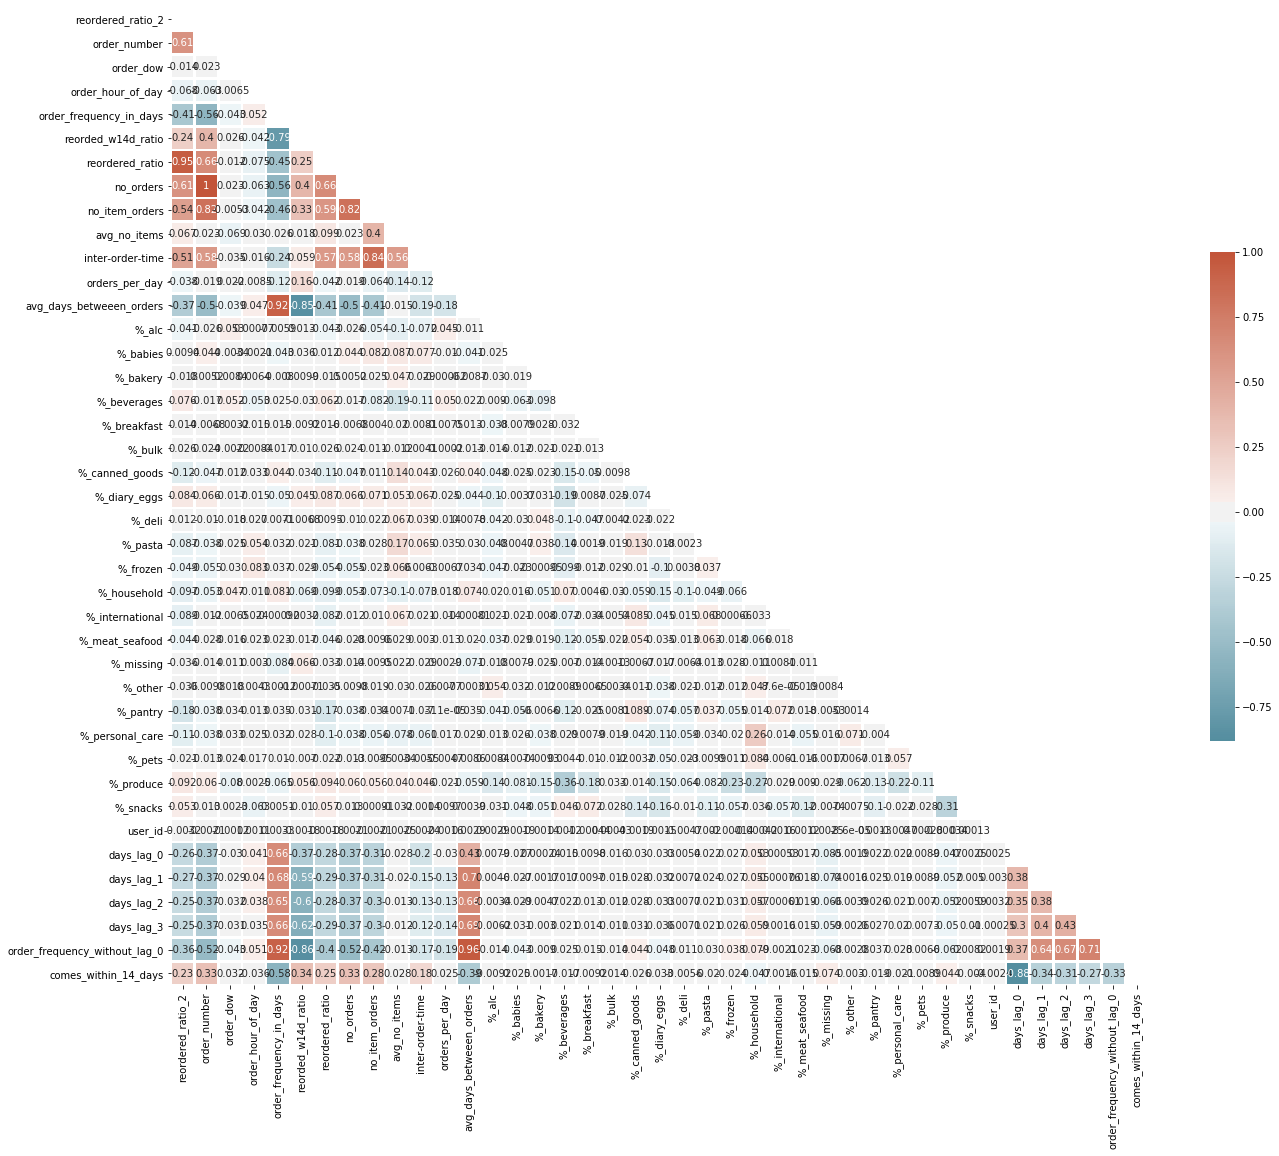

In [70]:
# Compute the correlation matrix
corr = df_4.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True,mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=1.5, cbar_kws={"shrink": .5})

In [24]:
df_4.head()

,Unnamed: 0,order_dow,order_hour_of_day,reorded_w14d_ratio,reordered_ratio,no_orders,no_item_orders,avg_no_items,inter-order-time,orders_per_day,...,%_personal_care,%_pets,%_produce,%_snacks,user_id,days_lag_1,days_lag_2,days_lag_3,order_frequency_without_lag_0,comes_within_14_days
0,0,2.500000,10.300000,0.288136,0.694915,10.0,59.0,5.900000,1094.0,0.009132,...,0.000000,0.0,0.084746,0.372881,1,0.0,14.0,20.0,18.250000,0
1,1,2.142857,10.571429,0.697436,0.476923,14.0,195.0,13.928571,2906.0,0.004816,...,0.005128,0.0,0.184615,0.215385,2,30.0,28.0,30.0,15.416667,1
2,2,1.083333,16.416667,0.738636,0.625000,12.0,88.0,7.333333,896.0,0.013378,...,0.000000,0.0,0.431818,0.102273,3,11.0,17.0,7.0,11.800000,0
3,3,4.800000,12.600000,0.388889,0.055556,5.0,18.0,3.600000,215.0,0.023148,...,0.000000,0.0,0.111111,0.055556,4,15.0,21.0,19.0,18.333333,1
4,4,1.750000,16.000000,0.675676,0.378378,4.0,37.0,9.250000,377.0,0.010582,...,0.000000,0.0,0.513514,0.027027,5,10.0,11.0,10.5,10.500000,0


In [71]:
df_4 = df_4.drop(columns=["order_number","order_frequency_in_days", "avg_days_betweeen_orders",
                          "reordered_ratio_2","days_lag_0"])

In [82]:
df_4 = df_4.drop(columns=["user_id"])

In [72]:
df_4.comes_within_14_days.value_counts()

0    105765
1    100444
Name: comes_within_14_days, dtype: int64

In [5]:
df_4 = pd.read_csv("retail_user_data.csv")

In [73]:
from scipy import stats
from scipy.stats import norm, skew

In [74]:
# Modeling 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
#!pip install xgboost
import xgboost as xgb
#!pip install catboost
from catboost import Pool, CatBoostClassifier
# Model tuning functions
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# Libraries to calculate various metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [75]:
numeric_feats = df_4.dtypes[df_4.dtypes !="object"].index

# Check the skew of all numerical features
skewed_feats = df_4[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(30)


Skew in numerical features: 



/Users/asmir/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


,Skew
orders_per_day,22.683342
%_bulk,22.265955
%_other,21.001439
%_missing,15.573470
%_pets,15.444647
%_alc,10.255025
%_babies,7.890887
%_international,7.394854
%_personal_care,7.135229
%_household,5.704704


In [ ]:
skewness = skewness[abs(skewness) > 1]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    X[feat] += 1
    X[feat] = boxcox1p(X[feat], lam)

## Train-Test Split

In [76]:
# create train test split on customers
from sklearn.model_selection import train_test_split

In [83]:
y = df_4['comes_within_14_days'].values
X = df_4.drop(['comes_within_14_days'], axis=1)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.20,
                                                    random_state =1)

In [79]:
#Train the XGboost Model for Binary Classification
xgb_model = xgb.XGBClassifier(n_estimators=500, # no. 500
                          max_depth=13, # tree depth #13, 9
                          learning_rate=0.03, #0.03
                          min_child_weight=6, #6
                          min_samples_split=3, #3,5
                          min_samples_leaf=3, #3,5
                          gamma=0, #0
                          subsample=0.8, #0.8
                          colsample_bytree=0.3, #0.6,0.8
                          #colsample_bylevel=0.2,
                          objective = 'binary:logistic',
                          #reg_alpha=6,
                          #reg_lambda=19.1,
                          seed=1) # a factor to multiply with weight updates from each treee

xgb_train_model = xgb_model.fit(X_train, y_train)

[22:11:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Classification Accuracy:  0.7396343533291305
Classification Error: 	 0.2603656466708695
Recall:  		 0.7062073771715864
Precision: 		 0.7457814224885665
F1 score: 		 0.725455103293107
AUC: 			 0.8321812271890818


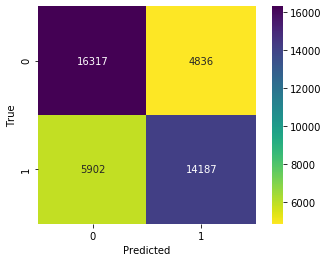

In [80]:
#Predictions and Classification Report
xgb_pred = xgb_train_model.predict(X_test)
# Probabilities are returned for each class, unfortunately without the class names
xgb_pred_prob = xgb_train_model.predict_proba(X_test)
xgb_pred_prob = xgb_pred_prob[:,1]

print('Classification Accuracy: ',   metrics.accuracy_score(y_test, xgb_pred))
print('Classification Error: \t',    1 - metrics.accuracy_score(y_test, xgb_pred))
print("Recall:  \t\t",               metrics.recall_score(y_test, xgb_pred))
print("Precision: \t\t",             metrics.precision_score(y_test, xgb_pred))
print("F1 score: \t\t",              metrics.f1_score(y_test, xgb_pred))
print('AUC: \t\t\t',                 metrics.roc_auc_score(y_test, xgb_pred_prob))

cm = confusion_matrix(y_test,xgb_pred)
ax = sns.heatmap(cm,cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

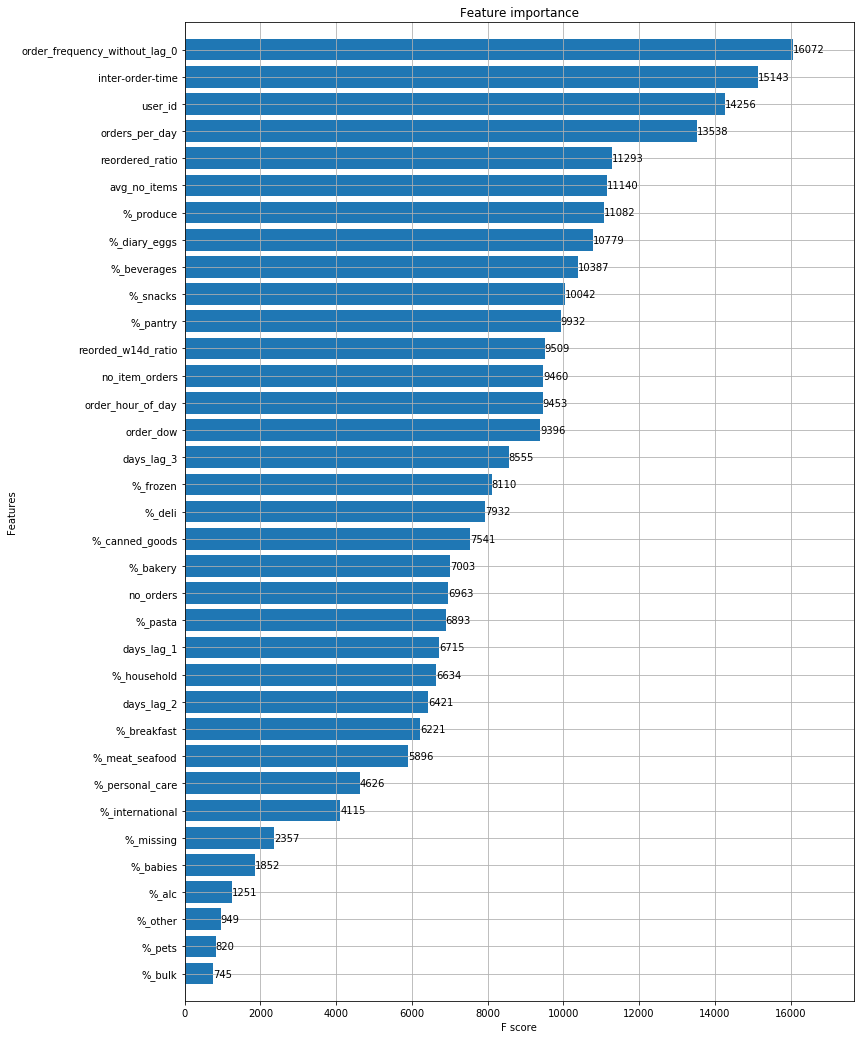

In [81]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xgb_train_model, max_num_features=100, height=0.8, ax=ax)
plt.show()

### Cat Boost

In [85]:
#cat_feat_ind = (X_train.dtypes == 'object')#.nonzero()[0] #specifying categorical features
pool_train = Pool(X_train, y_train)#, cat_features=cat_feat_ind)
pool_test = Pool(X_test, y_test)#, cat_features=cat_feat_ind)

cat_model = CatBoostClassifier(learning_rate=0.03,
                           iterations=2000,
                           early_stopping_rounds=100,
                           depth=9, #13,
                           l2_leaf_reg=5, #3
                           rsm=0.6,
                           subsample=0.7,#0.8
                           verbose=100,
                           random_state=1,
                           od_type='Iter')#,
                           #od_wait=200)
cat_model.fit(pool_train, eval_set=pool_test, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6811443	test: 0.6811995	best: 0.6811995 (0)	total: 324ms	remaining: 10m 46s
100:	learn: 0.5161277	test: 0.5197252	best: 0.5197252 (100)	total: 13.7s	remaining: 4m 18s
200:	learn: 0.5003175	test: 0.5082718	best: 0.5082718 (200)	total: 27.3s	remaining: 4m 3s
300:	learn: 0.4895694	test: 0.5019580	best: 0.5019580 (300)	total: 40.8s	remaining: 3m 50s
400:	learn: 0.4797272	test: 0.4963751	best: 0.4963751 (400)	total: 54.5s	remaining: 3m 37s
500:	learn: 0.4686796	test: 0.4890835	best: 0.4890835 (500)	total: 1m 7s	remaining: 3m 23s
600:	learn: 0.4600098	test: 0.4843303	best: 0.4843201 (599)	total: 1m 20s	remaining: 3m 6s
700:	learn: 0.4526660	test: 0.4819269	best: 0.4819269 (700)	total: 1m 33s	remaining: 2m 53s
800:	learn: 0.4458615	test: 0.4803486	best: 0.4803379 (799)	total: 1m 47s	remaining: 2m 40s
900:	learn: 0.4397919	test: 0.4790402	best: 0.4790348 (899)	total: 2m	remaining: 2m 26s
1000:	learn: 0.4337852	test: 0.4778942	best: 0.4778942 (1000)	total: 2m 14s	remaining: 2m 13s
1

Classification Accuracy:  0.7545220891324378
Classification Error: 	 0.2454779108675622
Recall:  		 0.7312957339837722
Precision: 		 0.7566050368234022
F1 score: 		 0.7437351288411888
AUC: 			 0.8465033456505493


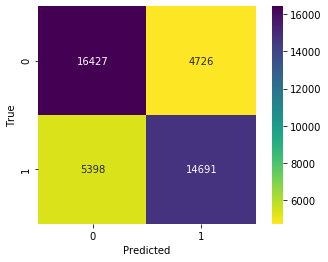

In [86]:
#Predictions and Classification Report
cat_pred = cat_model.predict(X_test)
# Probabilities are returned for each class, unfortunately without the class names
cat_pred_prob = cat_model.predict_proba(X_test)
cat_pred_prob = cat_pred_prob[:,1]

print('Classification Accuracy: ',   metrics.accuracy_score(y_test, cat_pred))
print('Classification Error: \t',    1 - metrics.accuracy_score(y_test, cat_pred))
print("Recall:  \t\t",               metrics.recall_score(y_test, cat_pred))
print("Precision: \t\t",             metrics.precision_score(y_test, cat_pred))
print("F1 score: \t\t",              metrics.f1_score(y_test, cat_pred))
print('AUC: \t\t\t',                 metrics.roc_auc_score(y_test, cat_pred_prob))

cm = confusion_matrix(y_test,cat_pred)
ax = sns.heatmap(cm,cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

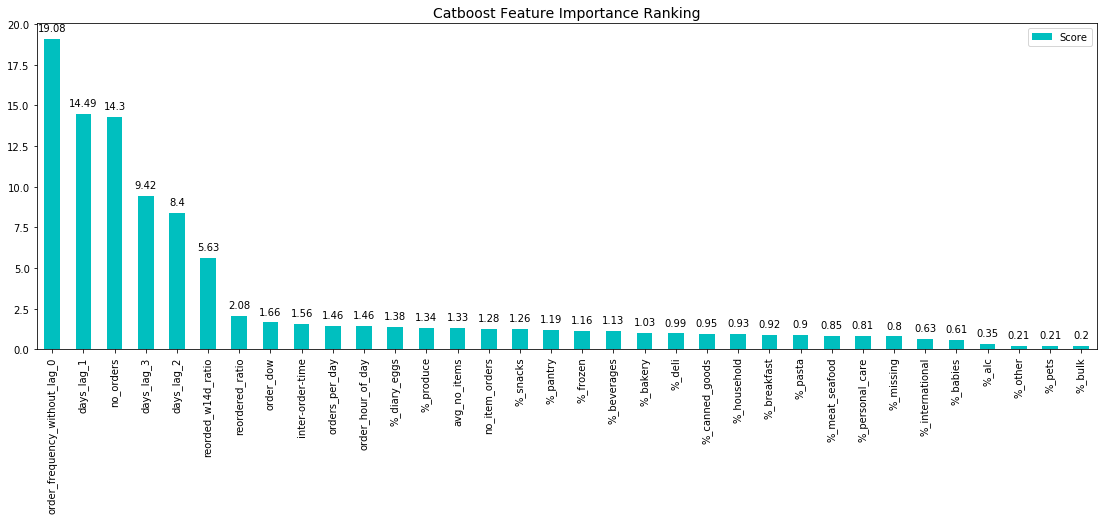

In [87]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, cat_model.get_feature_importance(Pool(X_train, label=y_train)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

# Predictions 

## Time shift for predictions

In [89]:
df

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reorded_w14d_ratio,reordered_ratio,no_orders,no_item_orders,avg_no_items,inter-order-time,orders_per_day,avg_days_betweeen_orders,%_alc,%_babies,%_bakery,%_beverages,%_breakfast,%_bulk,%_canned_goods,%_diary_eggs,%_deli,%_pasta,%_frozen,%_household,%_international,%_meat_seafood,%_missing,%_other,%_pantry,%_personal_care,%_pets,%_produce,%_snacks
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,3,5,9,8.0,0.384615,0.487179,7.0,78.0,11.142857,1389.0,0.005036,20.426471,0.0,0.000000,0.00,0.012821,0.000000,0.0,0.051282,0.128205,0.000,0.000000,0.000000,0.012821,0.000000,0.0,0.0,0.012821,0.461538,0.051282,0.0,0.25641,0.012821
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,3,5,9,8.0,0.384615,0.487179,7.0,78.0,11.142857,1389.0,0.005036,20.426471,0.0,0.000000,0.00,0.012821,0.000000,0.0,0.051282,0.128205,0.000,0.000000,0.000000,0.012821,0.000000,0.0,0.0,0.012821,0.461538,0.051282,0.0,0.25641,0.012821
2,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,3,5,9,8.0,0.384615,0.487179,7.0,78.0,11.142857,1389.0,0.005036,20.426471,0.0,0.000000,0.00,0.012821,0.000000,0.0,0.051282,0.128205,0.000,0.000000,0.000000,0.012821,0.000000,0.0,0.0,0.012821,0.461538,0.051282,0.0,0.25641,0.012821
3,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13,spreads,pantry,202279,3,5,9,8.0,0.384615,0.487179,7.0,78.0,11.142857,1389.0,0.005036,20.426471,0.0,0.000000,0.00,0.012821,0.000000,0.0,0.051282,0.128205,0.000,0.000000,0.000000,0.012821,0.000000,0.0,0.0,0.012821,0.461538,0.051282,0.0,0.25641,0.012821
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,3,5,9,8.0,0.384615,0.487179,7.0,78.0,11.142857,1389.0,0.005036,20.426471,0.0,0.000000,0.00,0.012821,0.000000,0.0,0.051282,0.128205,0.000,0.000000,0.000000,0.012821,0.000000,0.0,0.0,0.012821,0.461538,0.051282,0.0,0.25641,0.012821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,35211,5,0,Organic Strawberry & Mango Dried Tiny Fruits,92,18,baby food formula,babies,25247,24,2,6,21.0,0.916667,0.500000,26.0,240.0,9.230769,1723.0,0.015081,7.394850,0.0,0.033333,0.05,0.091667,0.020833,0.0,0.050000,0.154167,0.025,0.029167,0.029167,0.020833,0.004167,0.0,0.0,0.000000,0.079167,0.000000,0.0,0.30000,0.112500
32434485,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent,74,17,dish detergents,household,25247,24,2,6,21.0,0.916667,0.500000,26.0,240.0,9.230769,1723.0,0.015081,7.394850,0.0,0.033333,0.05,0.091667,0.020833,0.0,0.050000,0.154167,0.025,0.029167,0.029167,0.020833,0.004167,0.0,0.0,0.000000,0.079167,0.000000,0.0,0.30000,0.112500
32434486,3421083,11352,7,0,Organic Mini Sandwich Crackers Peanut Butter,78,19,crackers,snacks,25247,24,2,6,21.0,0.916667,0.500000,26.0,240.0,9.230769,1723.0,0.015081,7.394850,0.0,0.033333,0.05,0.091667,0.020833,0.0,0.050000,0.154167,0.025,0.029167,0.029167,0.020833,0.004167,0.0,0.0,0.000000,0.079167,0.000000,0.0,0.30000,0.112500
32434487,3421083,4600,8,0,All Natural French Toast Sticks,52,1,frozen breakfast,frozen,25247,24,2,6,21.0,0.916667,0.500000,26.0,240.0,9.230769,1723.0,0.015081,7.394850,0.0,0.033333,0.05,0.091667,0.020833,0.0,0.050000,0.154167,0.025,0.029167,0.029167,0.020833,0.004167,0.0,0.0,0.000000,0.079167,0.000000,0.0,0.30000,0.112500


### Build test dataset for prediction

In [90]:
df["reordered_14d"] = np.where(df["days_since_prior_order"] > 14,0,1)
df['reorded_w14d_ratio'] = df.groupby(['user_id'])['reordered_14d'].transform('mean')
df['reordered_ratio'] = df.groupby(['user_id'])['reordered'].transform('mean')
df['no_orders'] = df.groupby(['user_id'])['order_number'].transform('max')
df['no_item_orders'] = df.groupby(['user_id'])['product_id'].transform('count')
df['avg_no_items'] = df['no_item_orders']/df['no_orders']
df['inter-order-time'] = df.groupby(['user_id'])['days_since_prior_order'].transform('sum')
df['orders_per_day'] = df['no_orders']/(df['inter-order-time']+1)
df['avg_days_betweeen_orders'] = df.groupby(['user_id'])['days_since_prior_order'].transform('mean')
df = pd.get_dummies(df, prefix=['dep'], columns=['department'])
df['%_alc'] = df.groupby(['user_id'])['dep_alcohol'].transform('mean')
df['%_babies'] = df.groupby(['user_id'])['dep_babies'].transform('mean')
df['%_bakery'] = df.groupby(['user_id'])['dep_bakery'].transform('mean')
df['%_beverages'] = df.groupby(['user_id'])['dep_beverages'].transform('mean')
df['%_breakfast'] = df.groupby(['user_id'])['dep_breakfast'].transform('mean')
df['%_bulk'] = df.groupby(['user_id'])['dep_bulk'].transform('mean')
df['%_canned_goods'] = df.groupby(['user_id'])['dep_canned goods'].transform('mean')
df['%_diary_eggs'] = df.groupby(['user_id'])['dep_dairy eggs'].transform('mean')
df['%_deli'] = df.groupby(['user_id'])['dep_deli'].transform('mean')
df['%_pasta'] = df.groupby(['user_id'])['dep_dry goods pasta'].transform('mean')
df['%_frozen'] = df.groupby(['user_id'])['dep_frozen'].transform('mean')
df['%_household'] = df.groupby(['user_id'])['dep_household'].transform('mean')
df['%_international'] = df.groupby(['user_id'])['dep_international'].transform('mean')
df['%_meat_seafood'] = df.groupby(['user_id'])['dep_meat seafood'].transform('mean')
df['%_missing'] = df.groupby(['user_id'])['dep_missing'].transform('mean')
df['%_other'] = df.groupby(['user_id'])['dep_other'].transform('mean')
df['%_pantry'] = df.groupby(['user_id'])['dep_pantry'].transform('mean')
df['%_personal_care'] = df.groupby(['user_id'])['dep_personal care'].transform('mean')
df['%_pets'] = df.groupby(['user_id'])['dep_pets'].transform('mean')
df['%_produce'] = df.groupby(['user_id'])['dep_produce'].transform('mean')
df['%_snacks'] = df.groupby(['user_id'])['dep_snacks'].transform('mean')
df.drop(['dep_alcohol', 'dep_babies',
       'dep_bakery', 'dep_beverages', 'dep_breakfast', 'dep_bulk',
       'dep_canned goods', 'dep_dairy eggs', 'dep_deli', 'dep_dry goods pasta',
       'dep_frozen', 'dep_household', 'dep_international', 'dep_meat seafood',
       'dep_missing', 'dep_other', 'dep_pantry', 'dep_personal care',
       'dep_pets', 'dep_produce', 'dep_snacks'], axis=1, inplace=True)

In [91]:
test_2 = df.groupby(by="user_id").mean()
test_2

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reorded_w14d_ratio,reordered_ratio,no_orders,no_item_orders,avg_no_items,inter-order-time,orders_per_day,avg_days_betweeen_orders,%_alc,%_babies,%_bakery,%_beverages,%_breakfast,%_bulk,%_canned_goods,%_diary_eggs,%_deli,%_pasta,%_frozen,%_household,%_international,%_meat_seafood,%_missing,%_other,%_pantry,%_personal_care,%_pets,%_produce,%_snacks,reordered_14d
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.962396e+06,17885.966102,3.627119,0.694915,61.525424,14.000000,5.813559,2.644068,10.542373,20.259259,0.288136,0.694915,10.0,59.0,5.900000,1094.0,0.009132,20.259259,0.000000,0.000000,0.000000,0.220339,0.050847,0.0,0.000000,0.220339,0.000000,0.000000,0.000000,0.033898,0.000000,0.000000,0.000000,0.000000,0.016949,0.000000,0.0,0.084746,0.372881,0.288136
2,1.757602e+06,25398.015385,8.553846,0.476923,69.041026,12.600000,8.035897,2.005128,10.441026,15.967033,0.697436,0.476923,14.0,195.0,13.928571,2906.0,0.004816,15.967033,0.000000,0.000000,0.010256,0.046154,0.015385,0.0,0.005128,0.246154,0.107692,0.000000,0.087179,0.000000,0.015385,0.005128,0.000000,0.000000,0.056410,0.005128,0.0,0.184615,0.215385,0.697436
3,1.872658e+06,27459.238636,4.443182,0.625000,68.340909,9.443182,6.000000,1.011364,16.352273,11.487179,0.738636,0.625000,12.0,88.0,7.333333,896.0,0.013378,11.487179,0.000000,0.000000,0.000000,0.034091,0.000000,0.0,0.000000,0.238636,0.022727,0.045455,0.068182,0.011364,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.0,0.431818,0.102273,0.738636
4,1.674074e+06,23302.666667,2.777778,0.055556,71.222222,8.666667,2.888889,4.722222,13.111111,15.357143,0.388889,0.055556,5.0,18.0,3.600000,215.0,0.023148,15.357143,0.111111,0.000000,0.111111,0.166667,0.000000,0.0,0.055556,0.000000,0.111111,0.000000,0.166667,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.111111,0.055556,0.388889
5,1.629655e+06,22513.243243,5.513514,0.378378,77.378378,8.297297,2.486486,1.621622,15.729730,14.500000,0.675676,0.378378,4.0,37.0,9.250000,377.0,0.010582,14.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.027027,0.216216,0.027027,0.027027,0.054054,0.000000,0.054054,0.000000,0.000000,0.000000,0.054054,0.000000,0.0,0.513514,0.027027,0.675676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,1.270263e+06,28724.968750,6.781250,0.250000,74.375000,11.812500,1.687500,3.718750,13.625000,20.666667,0.750000,0.250000,3.0,32.0,10.666667,310.0,0.009646,20.666667,0.000000,0.031250,0.062500,0.031250,0.000000,0.0,0.000000,0.437500,0.093750,0.000000,0.062500,0.000000,0.000000,0.031250,0.031250,0.000000,0.000000,0.000000,0.0,0.218750,0.000000,0.750000
206206,1.898629e+06,27728.403509,3.835088,0.473684,62.859649,9.385965,38.007018,2.312281,16.796491,4.042705,0.975439,0.473684,67.0,285.0,4.253731,1136.0,0.058927,4.042705,0.000000,0.000000,0.007018,0.115789,0.003509,0.0,0.031579,0.136842,0.017544,0.003509,0.266667,0.042105,0.014035,0.007018,0.000000,0.003509,0.049123,0.035088,0.0,0.119298,0.147368,0.975439
206207,1.870273e+06,27029.632287,8.695067,0.587444,78.219731,10.686099,8.116592,2.896861,13.130045,14.879397,0.551570,0.587444,16.0,223.0,13.937500,2961.0,0.005402,14.879397,0.000000,0.004484,0.013453,0.089686,0.017937,0.0,0.049327,0.233184,0.035874,0.035874,0.094170,0.000000,0.004484,0.026906,0.000000,0.000000,0.067265,0.000000,0.0,0.224215,0.103139,0.551570


In [92]:
test_2 = test_2.drop(columns=["add_to_cart_order", "product_id"])
test_2 = test_2.rename(columns={"days_since_prior_order": "order_frequency_in_days"})
test_2 = test_2.rename(columns={"reordered": "reordered_ratio_2"})

In [93]:
# reset proper indexing of dataframe and add user_id as a column
test_2["user_id"]=test_2.index
test_2["user_id"]=test_2["user_id"].astype(int)
test_2 = test_2.reset_index(drop=True)

In [94]:
test_3 = test_2.copy()
test_3.head()

,order_id,reordered_ratio_2,aisle_id,department_id,order_number,order_dow,order_hour_of_day,order_frequency_in_days,reorded_w14d_ratio,reordered_ratio,no_orders,no_item_orders,avg_no_items,inter-order-time,orders_per_day,avg_days_betweeen_orders,%_alc,%_babies,%_bakery,%_beverages,%_breakfast,%_bulk,%_canned_goods,%_diary_eggs,%_deli,%_pasta,%_frozen,%_household,%_international,%_meat_seafood,%_missing,%_other,%_pantry,%_personal_care,%_pets,%_produce,%_snacks,reordered_14d,user_id
0,1.962396e+06,0.694915,61.525424,14.000000,5.813559,2.644068,10.542373,20.259259,0.288136,0.694915,10.0,59.0,5.900000,1094.0,0.009132,20.259259,0.000000,0.0,0.000000,0.220339,0.050847,0.0,0.000000,0.220339,0.000000,0.000000,0.000000,0.033898,0.000000,0.000000,0.0,0.0,0.016949,0.000000,0.0,0.084746,0.372881,0.288136,1
1,1.757602e+06,0.476923,69.041026,12.600000,8.035897,2.005128,10.441026,15.967033,0.697436,0.476923,14.0,195.0,13.928571,2906.0,0.004816,15.967033,0.000000,0.0,0.010256,0.046154,0.015385,0.0,0.005128,0.246154,0.107692,0.000000,0.087179,0.000000,0.015385,0.005128,0.0,0.0,0.056410,0.005128,0.0,0.184615,0.215385,0.697436,2
2,1.872658e+06,0.625000,68.340909,9.443182,6.000000,1.011364,16.352273,11.487179,0.738636,0.625000,12.0,88.0,7.333333,896.0,0.013378,11.487179,0.000000,0.0,0.000000,0.034091,0.000000,0.0,0.000000,0.238636,0.022727,0.045455,0.068182,0.011364,0.000000,0.000000,0.0,0.0,0.045455,0.000000,0.0,0.431818,0.102273,0.738636,3
3,1.674074e+06,0.055556,71.222222,8.666667,2.888889,4.722222,13.111111,15.357143,0.388889,0.055556,5.0,18.0,3.600000,215.0,0.023148,15.357143,0.111111,0.0,0.111111,0.166667,0.000000,0.0,0.055556,0.000000,0.111111,0.000000,0.166667,0.111111,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.111111,0.055556,0.388889,4
4,1.629655e+06,0.378378,77.378378,8.297297,2.486486,1.621622,15.729730,14.500000,0.675676,0.378378,4.0,37.0,9.250000,377.0,0.010582,14.500000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.027027,0.216216,0.027027,0.027027,0.054054,0.000000,0.054054,0.000000,0.0,0.0,0.054054,0.000000,0.0,0.513514,0.027027,0.675676,5


In [95]:
test_3 = test_3.drop(columns=["order_id"])

In [96]:
# merge all days_lag_n with df_3
test_3 = pd.merge(test_3, lag_days_0, how="left", on="user_id")
test_3 = pd.merge(test_3, lag_days_1, how="left", on="user_id")
test_3 = pd.merge(test_3, lag_days_2, how="left", on="user_id")
test_3 = pd.merge(test_3, lag_days_3, how="left", on="user_id")
test_3

,reordered_ratio_2,aisle_id,department_id,order_number,order_dow,order_hour_of_day,order_frequency_in_days,reorded_w14d_ratio,reordered_ratio,no_orders,no_item_orders,avg_no_items,inter-order-time,orders_per_day,avg_days_betweeen_orders,%_alc,%_babies,%_bakery,%_beverages,%_breakfast,%_bulk,%_canned_goods,%_diary_eggs,%_deli,%_pasta,%_frozen,%_household,%_international,%_meat_seafood,%_missing,%_other,%_pantry,%_personal_care,%_pets,%_produce,%_snacks,reordered_14d,user_id,days_lag_0,days_lag_1,days_lag_2,days_lag_3
0,0.694915,61.525424,14.000000,5.813559,2.644068,10.542373,20.259259,0.288136,0.694915,10.0,59.0,5.900000,1094.0,0.009132,20.259259,0.000000,0.000000,0.000000,0.220339,0.050847,0.0,0.000000,0.220339,0.000000,0.000000,0.000000,0.033898,0.000000,0.000000,0.000000,0.000000,0.016949,0.000000,0.0,0.084746,0.372881,0.288136,1,30.0,0.0,14.0,20.0
1,0.476923,69.041026,12.600000,8.035897,2.005128,10.441026,15.967033,0.697436,0.476923,14.0,195.0,13.928571,2906.0,0.004816,15.967033,0.000000,0.000000,0.010256,0.046154,0.015385,0.0,0.005128,0.246154,0.107692,0.000000,0.087179,0.000000,0.015385,0.005128,0.000000,0.000000,0.056410,0.005128,0.0,0.184615,0.215385,0.697436,2,13.0,30.0,28.0,30.0
2,0.625000,68.340909,9.443182,6.000000,1.011364,16.352273,11.487179,0.738636,0.625000,12.0,88.0,7.333333,896.0,0.013378,11.487179,0.000000,0.000000,0.000000,0.034091,0.000000,0.0,0.000000,0.238636,0.022727,0.045455,0.068182,0.011364,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.0,0.431818,0.102273,0.738636,3,15.0,11.0,17.0,7.0
3,0.055556,71.222222,8.666667,2.888889,4.722222,13.111111,15.357143,0.388889,0.055556,5.0,18.0,3.600000,215.0,0.023148,15.357143,0.111111,0.000000,0.111111,0.166667,0.000000,0.0,0.055556,0.000000,0.111111,0.000000,0.166667,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.111111,0.055556,0.388889,4,0.0,15.0,21.0,19.0
4,0.378378,77.378378,8.297297,2.486486,1.621622,15.729730,14.500000,0.675676,0.378378,4.0,37.0,9.250000,377.0,0.010582,14.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.027027,0.216216,0.027027,0.027027,0.054054,0.000000,0.054054,0.000000,0.000000,0.000000,0.054054,0.000000,0.0,0.513514,0.027027,0.675676,5,19.0,10.0,11.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,0.250000,74.375000,11.812500,1.687500,3.718750,13.625000,20.666667,0.750000,0.250000,3.0,32.0,10.666667,310.0,0.009646,20.666667,0.000000,0.031250,0.062500,0.031250,0.000000,0.0,0.000000,0.437500,0.093750,0.000000,0.062500,0.000000,0.000000,0.031250,0.031250,0.000000,0.000000,0.000000,0.0,0.218750,0.000000,0.750000,206205,10.0,30.0,NaN,NaN
206205,0.473684,62.859649,9.385965,38.007018,2.312281,16.796491,4.042705,0.975439,0.473684,67.0,285.0,4.253731,1136.0,0.058927,4.042705,0.000000,0.000000,0.007018,0.115789,0.003509,0.0,0.031579,0.136842,0.017544,0.003509,0.266667,0.042105,0.014035,0.007018,0.000000,0.003509,0.049123,0.035088,0.0,0.119298,0.147368,0.975439,206206,11.0,14.0,10.0,2.0
206206,0.587444,78.219731,10.686099,8.116592,2.896861,13.130045,14.879397,0.551570,0.587444,16.0,223.0,13.937500,2961.0,0.005402,14.879397,0.000000,0.004484,0.013453,0.089686,0.017937,0.0,0.049327,0.233184,0.035874,0.035874,0.094170,0.000000,0.004484,0.026906,0.000000,0.000000,0.067265,0.000000,0.0,0.224215,0.103139,0.551570,206207,18.0,7.0,4.0,30.0
206207,0.707533,74.224520,10.313146,25.505170,2.760709,13.968981,7.442105,0.906942,0.707533,49.0,677.0,13.816327,4949.0,0.009899,7.442105,0.000000,0.004431,0.091581,0.029542,0.025111,0.0,0.016248,0.237814,0.041359,0.025111,0.038405,0.008863,0.004431,0.032496,0.002954,0.000000,0.056130,0.007386,0.0,0.290990,0.087149,0.906942,206208,7.0,5.0,9.0,13.0


In [97]:
# calculate mean frequency without days_lag_0
# formula = (mean * n - x0)/(n-1)
# mind that no_orders = n+1
test_3["order_frequency_without_lag_0"] = (test_3["order_frequency_in_days"] * (test_3["no_orders"]-1)-test_3["days_lag_0"])/(test_3["no_orders"]-2)
test_3

,reordered_ratio_2,aisle_id,department_id,order_number,order_dow,order_hour_of_day,order_frequency_in_days,reorded_w14d_ratio,reordered_ratio,no_orders,no_item_orders,avg_no_items,inter-order-time,orders_per_day,avg_days_betweeen_orders,%_alc,%_babies,%_bakery,%_beverages,%_breakfast,%_bulk,%_canned_goods,%_diary_eggs,%_deli,%_pasta,%_frozen,%_household,%_international,%_meat_seafood,%_missing,%_other,%_pantry,%_personal_care,%_pets,%_produce,%_snacks,reordered_14d,user_id,days_lag_0,days_lag_1,days_lag_2,days_lag_3,order_frequency_without_lag_0
0,0.694915,61.525424,14.000000,5.813559,2.644068,10.542373,20.259259,0.288136,0.694915,10.0,59.0,5.900000,1094.0,0.009132,20.259259,0.000000,0.000000,0.000000,0.220339,0.050847,0.0,0.000000,0.220339,0.000000,0.000000,0.000000,0.033898,0.000000,0.000000,0.000000,0.000000,0.016949,0.000000,0.0,0.084746,0.372881,0.288136,1,30.0,0.0,14.0,20.0,19.041667
1,0.476923,69.041026,12.600000,8.035897,2.005128,10.441026,15.967033,0.697436,0.476923,14.0,195.0,13.928571,2906.0,0.004816,15.967033,0.000000,0.000000,0.010256,0.046154,0.015385,0.0,0.005128,0.246154,0.107692,0.000000,0.087179,0.000000,0.015385,0.005128,0.000000,0.000000,0.056410,0.005128,0.0,0.184615,0.215385,0.697436,2,13.0,30.0,28.0,30.0,16.214286
2,0.625000,68.340909,9.443182,6.000000,1.011364,16.352273,11.487179,0.738636,0.625000,12.0,88.0,7.333333,896.0,0.013378,11.487179,0.000000,0.000000,0.000000,0.034091,0.000000,0.0,0.000000,0.238636,0.022727,0.045455,0.068182,0.011364,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.0,0.431818,0.102273,0.738636,3,15.0,11.0,17.0,7.0,11.135897
3,0.055556,71.222222,8.666667,2.888889,4.722222,13.111111,15.357143,0.388889,0.055556,5.0,18.0,3.600000,215.0,0.023148,15.357143,0.111111,0.000000,0.111111,0.166667,0.000000,0.0,0.055556,0.000000,0.111111,0.000000,0.166667,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.111111,0.055556,0.388889,4,0.0,15.0,21.0,19.0,20.476190
4,0.378378,77.378378,8.297297,2.486486,1.621622,15.729730,14.500000,0.675676,0.378378,4.0,37.0,9.250000,377.0,0.010582,14.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.027027,0.216216,0.027027,0.027027,0.054054,0.000000,0.054054,0.000000,0.000000,0.000000,0.054054,0.000000,0.0,0.513514,0.027027,0.675676,5,19.0,10.0,11.0,NaN,12.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,0.250000,74.375000,11.812500,1.687500,3.718750,13.625000,20.666667,0.750000,0.250000,3.0,32.0,10.666667,310.0,0.009646,20.666667,0.000000,0.031250,0.062500,0.031250,0.000000,0.0,0.000000,0.437500,0.093750,0.000000,0.062500,0.000000,0.000000,0.031250,0.031250,0.000000,0.000000,0.000000,0.0,0.218750,0.000000,0.750000,206205,10.0,30.0,NaN,NaN,31.333333
206205,0.473684,62.859649,9.385965,38.007018,2.312281,16.796491,4.042705,0.975439,0.473684,67.0,285.0,4.253731,1136.0,0.058927,4.042705,0.000000,0.000000,0.007018,0.115789,0.003509,0.0,0.031579,0.136842,0.017544,0.003509,0.266667,0.042105,0.014035,0.007018,0.000000,0.003509,0.049123,0.035088,0.0,0.119298,0.147368,0.975439,206206,11.0,14.0,10.0,2.0,3.935669
206206,0.587444,78.219731,10.686099,8.116592,2.896861,13.130045,14.879397,0.551570,0.587444,16.0,223.0,13.937500,2961.0,0.005402,14.879397,0.000000,0.004484,0.013453,0.089686,0.017937,0.0,0.049327,0.233184,0.035874,0.035874,0.094170,0.000000,0.004484,0.026906,0.000000,0.000000,0.067265,0.000000,0.0,0.224215,0.103139,0.551570,206207,18.0,7.0,4.0,30.0,14.656497
206207,0.707533,74.224520,10.313146,25.505170,2.760709,13.968981,7.442105,0.906942,0.707533,49.0,677.0,13.816327,4949.0,0.009899,7.442105,0.000000,0.004431,0.091581,0.029542,0.025111,0.0,0.016248,0.237814,0.041359,0.025111,0.038405,0.008863,0.004431,0.032496,0.002954,0.000000,0.056130,0.007386,0.0,0.290990,0.087149,0.906942,206208,7.0,5.0,9.0,13.0,7.451512


In [98]:
# impute days_lag_2 and days_lag_3 with mean
test_4 = test_3.copy()
test_4.days_lag_3[test_4.days_lag_3.isna()] = test_4.order_frequency_without_lag_0[test_4.days_lag_3.isna()]
test_4.days_lag_2[test_4.days_lag_2.isna()] = test_4.order_frequency_without_lag_0[test_4.days_lag_2.isna()]
test_4

,reordered_ratio_2,aisle_id,department_id,order_number,order_dow,order_hour_of_day,order_frequency_in_days,reorded_w14d_ratio,reordered_ratio,no_orders,no_item_orders,avg_no_items,inter-order-time,orders_per_day,avg_days_betweeen_orders,%_alc,%_babies,%_bakery,%_beverages,%_breakfast,%_bulk,%_canned_goods,%_diary_eggs,%_deli,%_pasta,%_frozen,%_household,%_international,%_meat_seafood,%_missing,%_other,%_pantry,%_personal_care,%_pets,%_produce,%_snacks,reordered_14d,user_id,days_lag_0,days_lag_1,days_lag_2,days_lag_3,order_frequency_without_lag_0
0,0.694915,61.525424,14.000000,5.813559,2.644068,10.542373,20.259259,0.288136,0.694915,10.0,59.0,5.900000,1094.0,0.009132,20.259259,0.000000,0.000000,0.000000,0.220339,0.050847,0.0,0.000000,0.220339,0.000000,0.000000,0.000000,0.033898,0.000000,0.000000,0.000000,0.000000,0.016949,0.000000,0.0,0.084746,0.372881,0.288136,1,30.0,0.0,14.000000,20.000000,19.041667
1,0.476923,69.041026,12.600000,8.035897,2.005128,10.441026,15.967033,0.697436,0.476923,14.0,195.0,13.928571,2906.0,0.004816,15.967033,0.000000,0.000000,0.010256,0.046154,0.015385,0.0,0.005128,0.246154,0.107692,0.000000,0.087179,0.000000,0.015385,0.005128,0.000000,0.000000,0.056410,0.005128,0.0,0.184615,0.215385,0.697436,2,13.0,30.0,28.000000,30.000000,16.214286
2,0.625000,68.340909,9.443182,6.000000,1.011364,16.352273,11.487179,0.738636,0.625000,12.0,88.0,7.333333,896.0,0.013378,11.487179,0.000000,0.000000,0.000000,0.034091,0.000000,0.0,0.000000,0.238636,0.022727,0.045455,0.068182,0.011364,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.0,0.431818,0.102273,0.738636,3,15.0,11.0,17.000000,7.000000,11.135897
3,0.055556,71.222222,8.666667,2.888889,4.722222,13.111111,15.357143,0.388889,0.055556,5.0,18.0,3.600000,215.0,0.023148,15.357143,0.111111,0.000000,0.111111,0.166667,0.000000,0.0,0.055556,0.000000,0.111111,0.000000,0.166667,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.111111,0.055556,0.388889,4,0.0,15.0,21.000000,19.000000,20.476190
4,0.378378,77.378378,8.297297,2.486486,1.621622,15.729730,14.500000,0.675676,0.378378,4.0,37.0,9.250000,377.0,0.010582,14.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.027027,0.216216,0.027027,0.027027,0.054054,0.000000,0.054054,0.000000,0.000000,0.000000,0.054054,0.000000,0.0,0.513514,0.027027,0.675676,5,19.0,10.0,11.000000,12.250000,12.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,0.250000,74.375000,11.812500,1.687500,3.718750,13.625000,20.666667,0.750000,0.250000,3.0,32.0,10.666667,310.0,0.009646,20.666667,0.000000,0.031250,0.062500,0.031250,0.000000,0.0,0.000000,0.437500,0.093750,0.000000,0.062500,0.000000,0.000000,0.031250,0.031250,0.000000,0.000000,0.000000,0.0,0.218750,0.000000,0.750000,206205,10.0,30.0,31.333333,31.333333,31.333333
206205,0.473684,62.859649,9.385965,38.007018,2.312281,16.796491,4.042705,0.975439,0.473684,67.0,285.0,4.253731,1136.0,0.058927,4.042705,0.000000,0.000000,0.007018,0.115789,0.003509,0.0,0.031579,0.136842,0.017544,0.003509,0.266667,0.042105,0.014035,0.007018,0.000000,0.003509,0.049123,0.035088,0.0,0.119298,0.147368,0.975439,206206,11.0,14.0,10.000000,2.000000,3.935669
206206,0.587444,78.219731,10.686099,8.116592,2.896861,13.130045,14.879397,0.551570,0.587444,16.0,223.0,13.937500,2961.0,0.005402,14.879397,0.000000,0.004484,0.013453,0.089686,0.017937,0.0,0.049327,0.233184,0.035874,0.035874,0.094170,0.000000,0.004484,0.026906,0.000000,0.000000,0.067265,0.000000,0.0,0.224215,0.103139,0.551570,206207,18.0,7.0,4.000000,30.000000,14.656497
206207,0.707533,74.224520,10.313146,25.505170,2.760709,13.968981,7.442105,0.906942,0.707533,49.0,677.0,13.816327,4949.0,0.009899,7.442105,0.000000,0.004431,0.091581,0.029542,0.025111,0.0,0.016248,0.237814,0.041359,0.025111,0.038405,0.008863,0.004431,0.032496,0.002954,0.000000,0.056130,0.007386,0.0,0.290990,0.087149,0.906942,206208,7.0,5.0,9.000000,13.000000

In [99]:
test_4 = test_4.drop(columns=["order_number","order_frequency_in_days", "avg_days_betweeen_orders",
                          "reordered_ratio_2","days_lag_3", "user_id"])

In [110]:
test_4

,order_dow,order_hour_of_day,reorded_w14d_ratio,reordered_ratio,no_orders,no_item_orders,avg_no_items,inter-order-time,orders_per_day,%_alc,%_babies,%_bakery,%_beverages,%_breakfast,%_bulk,%_canned_goods,%_diary_eggs,%_deli,%_pasta,%_frozen,%_household,%_international,%_meat_seafood,%_missing,%_other,%_pantry,%_personal_care,%_pets,%_produce,%_snacks,days_lag_1,days_lag_2,days_lag_3,order_frequency_without_lag_0
0,2.644068,10.542373,0.288136,0.694915,10.0,59.0,5.900000,1094.0,0.009132,0.000000,0.000000,0.000000,0.220339,0.050847,0.0,0.000000,0.220339,0.000000,0.000000,0.000000,0.033898,0.000000,0.000000,0.000000,0.000000,0.016949,0.000000,0.0,0.084746,0.372881,30.0,0.0,14.000000,19.041667
1,2.005128,10.441026,0.697436,0.476923,14.0,195.0,13.928571,2906.0,0.004816,0.000000,0.000000,0.010256,0.046154,0.015385,0.0,0.005128,0.246154,0.107692,0.000000,0.087179,0.000000,0.015385,0.005128,0.000000,0.000000,0.056410,0.005128,0.0,0.184615,0.215385,13.0,30.0,28.000000,16.214286
2,1.011364,16.352273,0.738636,0.625000,12.0,88.0,7.333333,896.0,0.013378,0.000000,0.000000,0.000000,0.034091,0.000000,0.0,0.000000,0.238636,0.022727,0.045455,0.068182,0.011364,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.0,0.431818,0.102273,15.0,11.0,17.000000,11.135897
3,4.722222,13.111111,0.388889,0.055556,5.0,18.0,3.600000,215.0,0.023148,0.111111,0.000000,0.111111,0.166667,0.000000,0.0,0.055556,0.000000,0.111111,0.000000,0.166667,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.111111,0.055556,0.0,15.0,21.000000,20.476190
4,1.621622,15.729730,0.675676,0.378378,4.0,37.0,9.250000,377.0,0.010582,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.027027,0.216216,0.027027,0.027027,0.054054,0.000000,0.054054,0.000000,0.000000,0.000000,0.054054,0.000000,0.0,0.513514,0.027027,19.0,10.0,11.000000,12.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,3.718750,13.625000,0.750000,0.250000,3.0,32.0,10.666667,310.0,0.009646,0.000000,0.031250,0.062500,0.031250,0.000000,0.0,0.000000,0.437500,0.093750,0.000000,0.062500,0.000000,0.000000,0.031250,0.031250,0.000000,0.000000,0.000000,0.0,0.218750,0.000000,10.0,30.0,31.333333,31.333333
206205,2.312281,16.796491,0.975439,0.473684,67.0,285.0,4.253731,1136.0,0.058927,0.000000,0.000000,0.007018,0.115789,0.003509,0.0,0.031579,0.136842,0.017544,0.003509,0.266667,0.042105,0.014035,0.007018,0.000000,0.003509,0.049123,0.035088,0.0,0.119298,0.147368,11.0,14.0,10.000000,3.935669
206206,2.896861,13.130045,0.551570,0.587444,16.0,223.0,13.937500,2961.0,0.005402,0.000000,0.004484,0.013453,0.089686,0.017937,0.0,0.049327,0.233184,0.035874,0.035874,0.094170,0.000000,0.004484,0.026906,0.000000,0.000000,0.067265,0.000000,0.0,0.224215,0.103139,18.0,7.0,4.000000,14.656497
206207,2.760709,13.968981,0.906942,0.707533,49.0,677.0,13.816327,4949.0,0.009899,0.000000,0.004431,0.091581,0.029542,0.025111,0.0,0.016248,0.237814,0.041359,0.025111,0.038405,0.008863,0.004431,0.032496,0.002954,0.000000,0.056130,0.007386,0.0,0.290990,0.087149,7.0,5.0,9.000000,7.451512


In [103]:
test_4 = test_4.drop(columns=["aisle_id", "department_id"])

In [107]:
test_4 = test_4.drop(columns=["reordered_14d"])

In [109]:
test_4 = test_4.rename(columns={"days_lag_0": "days_lag_1",
                                "days_lag_1":"days_lag_2",
                                "days_lag_2":"days_lag_3"})

In [114]:
test_4.to_csv("test_4.csv")

In [112]:
prediction_index["yhat"] = cat_model.predict_proba(test_4)[:,1]
prediction_index

,user_id,order_number,yhat
0,1,11,0.234027
1,2,15,0.327902
2,3,13,0.400082
3,4,6,0.746593
4,5,5,0.284903
...,...,...,...
206204,206205,4,0.999273
206205,206206,68,0.766844
206206,206207,17,0.482248
206207,206208,50,0.943289


In [113]:
prediction_index.to_parquet("e02-06b.parquet")